## TOC:
* [Reading CVS files](#first-bullet)
* [Luminosity section](#second-bullet)
* [Trigger rate section](#third-bullet)
* [Model training section](#fourth-bullet)

In [1]:
import math
import json
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D,\
UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.externals import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn import cluster, datasets

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
runs = [319579, 321312]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"

# Reading cvs and json files <a class="anchor" id="first-bullet"></a>

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [4]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered",\
               "recorded", "avgpu", "source"]), 
        ignore_index=True)
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4",\
               "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True)
print("Done.")

Loading 319579
Loading 321312
Done.


Reading the certified lumimask:

In [5]:
path = "./lumimasks/Cert_314472-321777_13TeV_PromptReco_Collisions18_JSON.json"
df_lumimask = pd.DataFrame()
df_lumimask = pd.read_json(path, typ='series')
df_lumimask = df_lumimask.to_frame()
df_lumimask = df_lumimask.reset_index()
df_lumimask = df_lumimask.rename(columns= {'index': 'run', 0: 'ls'})
df_lumimask["ls"] = df_lumimask["ls"].apply(np.array)

# Luminosity section <a class="anchor" id="second-bullet"></a>

Dropping useless rows inherited from the lumi CVS file:

In [6]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill field and the start and end lumi sections:

In [7]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [8]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [9]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [10]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [11]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print i, start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1],\
                                    "nLS": nLS}, ignore_index = True)

319579 2018-07-13 04:27:45 2018-07-14 01:00:07 1 3173 3173
321312 2018-08-15 20:55:17 2018-08-16 01:55:14 1 773 773


In [12]:
boundaries = boundaries.sort_values('run')
boundaries = boundaries.reset_index()

Reindexing the dataframe after removing some lines:

In [13]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [14]:
print len(int_lumi2.index)

3946


Filling end time column:

In [15]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

Selecting only beam status STABLE BEAM:

In [16]:
#print int_lumi2["beamstatus"]
int_lumi2 = int_lumi2[int_lumi2["beamstatus"] == "STABLE BEAMS"]

Removing not certified runs from the reference run:

In [17]:
def apply_lumimask(run, df, df_lm):
    temp = df.copy()
    mat = df_lm[df_lm.run == run].ls.iloc[0]
    for i in range(0, np.size(mat, 0)):
        print "Applying lumi mask:", mat[i]
        ls_i = int(mat[i][0])
        ls_f = int(mat[i][1])
        temp = temp[(temp.ls_start >= ls_i) & (temp.ls_start <= ls_f)]
    return temp

In [18]:
int_lumi2 = apply_lumimask(319579, int_lumi2, df_lumimask)

Applying lumi mask: [  41 3168]


In [19]:
#int_lumi2.to_csv("int_lumi2.csv", sep='\t')

Plotting the instantaneous luminosities:

In [20]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel(r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

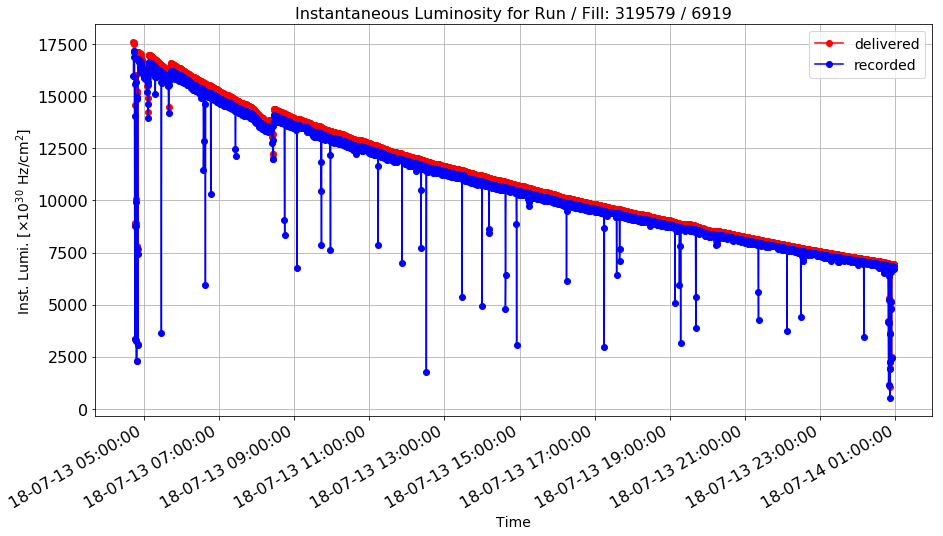

In [22]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 319579]["time"], 
               int_lumi2[int_lumi2["run"] == 319579]["delivered"], 
               int_lumi2[int_lumi2["run"] == 319579]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("319579", int_lumi2[int_lumi2.run == 319579]["fill"].iloc[0])))

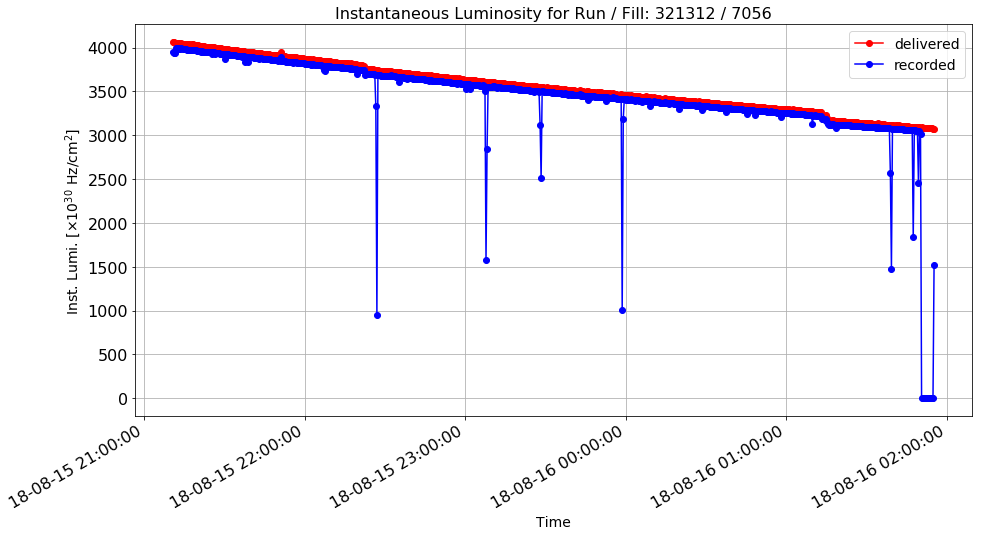

In [23]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 321312]["time"], 
               int_lumi2[int_lumi2["run"] == 321312]["delivered"], 
               int_lumi2[int_lumi2["run"] == 321312]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("321312", int_lumi2[int_lumi2.run == 321312]["fill"].iloc[0])))

# Trigger rate section <a class="anchor" id="third-bullet"></a>

Converting columns to proper data types:

In [24]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Splitting, converting and adding new columns:

In [25]:
df_rates["board"].replace(regex=True,inplace=True,to_replace=r'm',value=r'-')
df_rates["board"].replace(regex=True,inplace=True,to_replace=r'p',value=r'+')
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [26]:
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
df_rates["ls"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates.to_csv("df_rates.csv", sep='\t')

Plotting the rate coming from one of the stations:

In [27]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

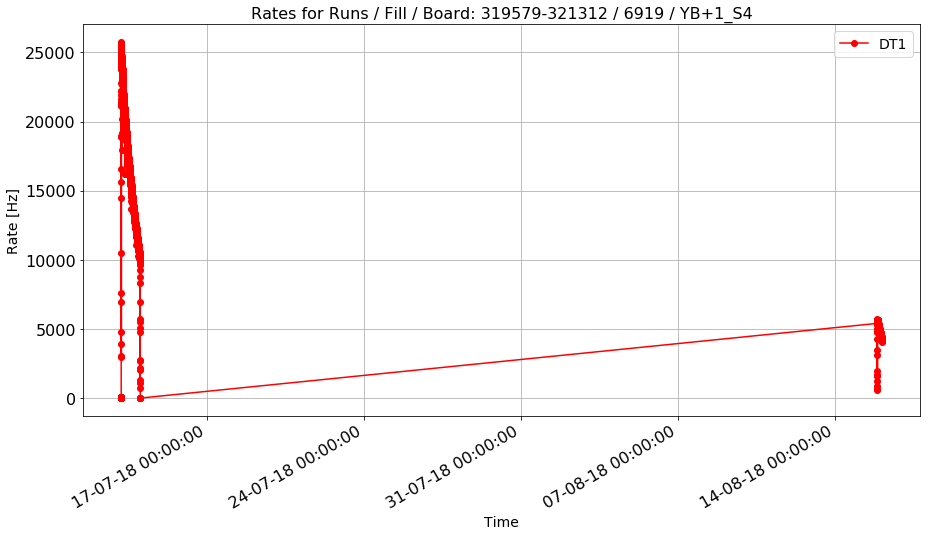

In [28]:
rule = (df_rates.run != 305814)
plot_rate_vs_time(df_rates[rule],\
                  "time", "DT1", "YB+1_S4", "Rates for Runs / Fill / Board: %s / %s / %s" % 
                  (str(boundaries["run"].iloc[0])+"-"+str(boundaries["run"].iloc[1]), 
                   int_lumi2["fill"].iloc[1], "YB+1_S4"))

Associating a LS and an instantaneous luminosity to each rate:

In [29]:
#Just a backup copy
df_rates_backup = df_rates.copy()

In [30]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Removing the measurements taken before and after the start and end time reported by the brilcalc output. All the 60 boards are measured at the same time. In order to speed-up the association, we take just one board, the first one. This reduces the dataframe and the time needed to go though it by a factor of 60.

In [31]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["end"].iloc[-1]
print time0, timeF
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print "Duplicates:", rule.sum()
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

2018-07-13 04:27:45 2018-08-16 01:55:14
Duplicates: 270869


In [32]:
print len(df_rates_noduplicates)

4591


Assigning the LS and the inst. lumi. to the measurements for the selected board:

In [33]:
def assignLS(df1, df2, boundaries):
    temp = df1.copy()
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%1000 == 0): 
                    print j
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                temp.loc[index1, "ls"] = ls
                temp.loc[index1, "lumi"] = lumi
                break
    return temp

temp = assignLS(df_rates_noduplicates, int_lumi2, boundaries)
df_rates_noduplicates = temp

1000
2000
3000
4000


Removing the few cases not assigned and that are still at -1:

In [34]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
print len(df_rates_noduplicates)

4486


Save in a csv file:

In [35]:
#df_rates.to_csv("df_rates.csv", sep='\t')
#df_rates_noduplicates.to_csv("df_rates_nodup.csv", sep='\t')

In [36]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Assign the LS and the inst. lumi. to all the 60 boards for each time:

In [37]:
def assignLS_ext(df1, df2):
    temp = df1.copy()
    indexes = []
    for index in df2.index:
        if index%10000 == 0:
            print index
        time = df2["time"].loc[index]
        ls = df2["ls"].loc[index]
        lumi = df2["lumi"].loc[index]
        des = (temp["time"] == time)
        indexes = temp[des].index
        #print time, ls, indexes
        temp.loc[des, "ls"] = ls
        temp.loc[des, "lumi"] = lumi
    return temp
    
temp = assignLS_ext(df_rates, df_rates_noduplicates)

30000
60000
90000
120000
150000
180000
210000
240000
270000


In [38]:
df_rates = temp.copy()
#print df_rates[df_rates.ls <= 0]

Removing measurements without LS assignment:

In [39]:
df_rates_backup = df_rates.copy()
df_rates = df_rates[df_rates.ls > 0]
#print df_rates["ls"]

In [40]:
#print df_rates[df_rates.ls <= 0]
#df_rates.to_csv("df_rates.csv", sep='\t')

Averaging the rates associated to the same LS:

In [41]:
df_boards = df_rates.copy()
df_boards = df_boards.groupby(['board']).size().reset_index(name='counts')
print len(df_boards)
#print df_boards

60


Too slow to use all the measurements. Averaging over 10 LS:

In [42]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

In [43]:
bunch = 10
def assignGroup(data, div = bunch):
    res = int(data/div)
    #print data, res
    return res

df_rates["group"] = df_rates["ls"]
df_rates["group"] = df_rates["group"].apply(assignGroup)

In [44]:
#print df_rates["group"]

In [45]:
temp1 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4",\
  "DT1", "DT2", "DT3", "DT4", "DT5"]].mean().reset_index()

temp2 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4",\
  "DT1", "DT2", "DT3", "DT4", "DT5"]].std().reset_index()

temp3 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4",\
  "DT1", "DT2", "DT3", "DT4", "DT5"]].size().reset_index(name='counts')

temp2 = temp2.rename(index=str, columns={"lumi": "errLumi", "RPC1": "errRPC1", "RPC2": "errRPC2",\
                                         "RPC3": "errRPC3", "RPC4": "errRPC4", "DT1": "errDT1",\
                                         "DT2": "errDT2", "DT3": "errDT3", "DT4":\
                                         "errDT4", "DT5": "errDT5"})

cols_to_use2 = temp2.columns.difference(temp1.columns)
cols_to_use3 = temp3.columns.difference(temp1.columns)

temp2 = temp2[cols_to_use2]
temp3 = temp3[cols_to_use3]

#print temp1.iloc[100]
#print temp2.iloc[100]
#print temp3.iloc[100]

temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
temp3.reset_index(drop=True, inplace=True)

df_rates = pd.concat([temp1, temp2, temp3], axis = 1)

Calculating the errors on the mean values calculated in the previous step:

In [46]:
import math
def applySqrt(data):
    return math.sqrt(data)

df_rates["counts"] = df_rates["counts"].apply(applySqrt)

for i in list(df_rates):
    if "err" in i:
        #print i
        df_rates[i] = df_rates[i]/df_rates["counts"]

In [47]:
#print df_rates

Check for null or NaN values:

In [48]:
print df_rates.isnull().values.any()
null_columns=df_rates.columns[df_rates.isnull().any()]
print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())
#df_rates = df_rates.fillna(0)
#print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())

False
Empty DataFrame
Columns: []
Index: []


In [49]:
#Another backup
#df_rates_backup = df_rates.copy()
#df_rates.to_csv("df_rates.csv", sep='\t')

In [50]:
#Restore backup
#df_rates = df_rates_backup.copy()

In [51]:
print len(df_rates)

23160


Uncomment to check just one case case:

In [52]:
#for index, row in df_rates.iterrows():
    #if row["board"] == "YB0_S1":
        #print "Index:", index,", Run:", row["run"],", Board: ",row["board"],",\
        #LS: ",row["ls"],", Rate: ",row["DT1"],", Error: ",row["errDT1"]

Plotting the result:

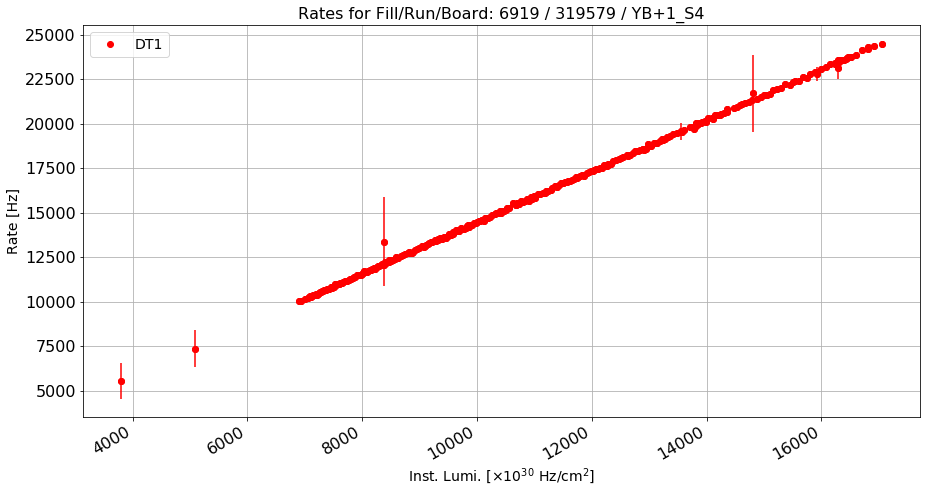

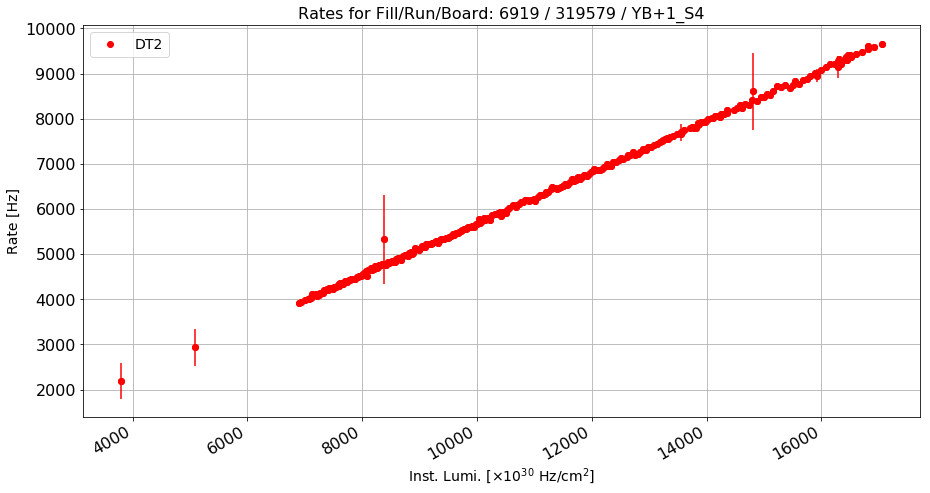

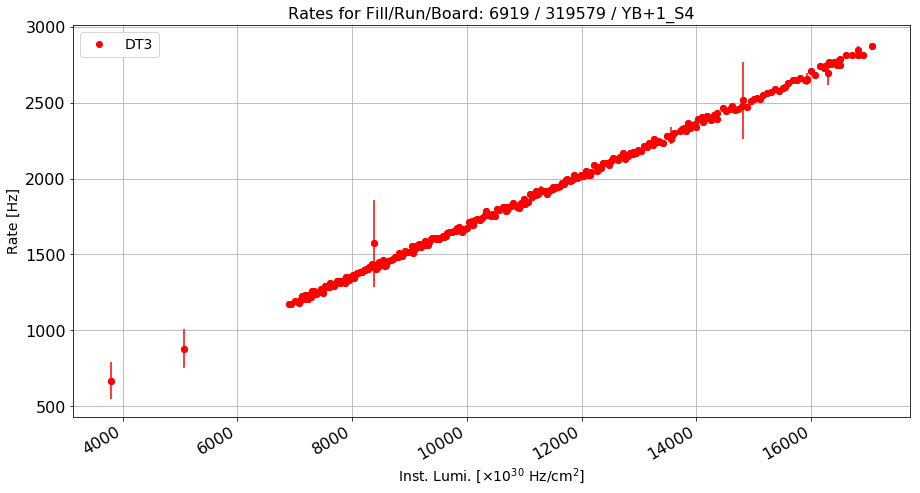

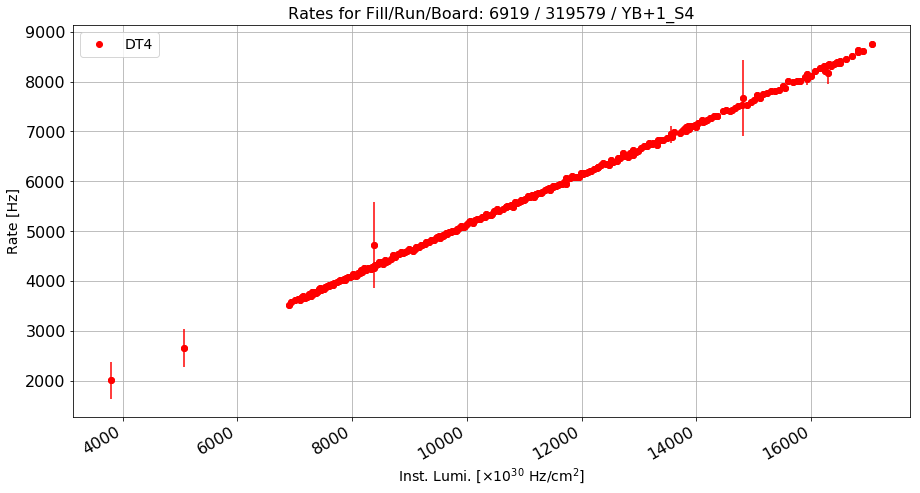

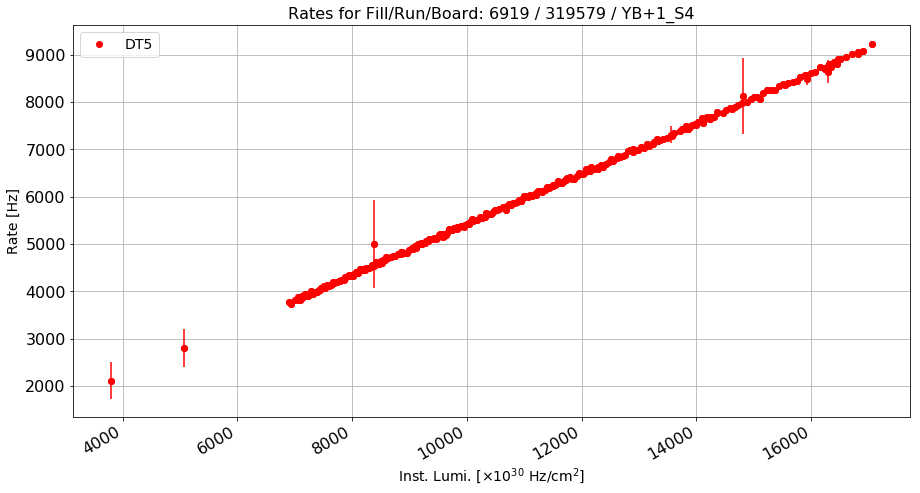

In [53]:
def plot_rate_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run))
    df_temp = df_temp[rule]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

title = "Rates for Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "\
+str(boundaries["run"].iloc[0])+" / YB+1_S4"

plot_rate_vs_ls(df_rates, 319579, "lumi", "DT1", "YB+1_S4", 0, "errDT1",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 319579, "lumi", "DT2", "YB+1_S4", 0, "errDT2",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 319579, "lumi", "DT3", "YB+1_S4", 0, "errDT3",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 319579, "lumi", "DT4", "YB+1_S4", 0, "errDT4",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 319579, "lumi", "DT5", "YB+1_S4", 0, "errDT5",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")

Create a new dataframe with the input features already organized in a numpy array:

In [54]:
print len(df_rates)
#Uncomment to include RPC
#algos = ['RPC1', 'RPC2', 'RPC3', 'RPC4', 'DT1', 'DT2', 'DT3', 'DT4', 'DT5']
algos = ['DT1', 'DT2', 'DT3', 'DT4', 'DT5']
df_rates_new_2 = pd.DataFrame(columns=['run', 'group', 'board', 'wheel', 'sector', 'ls',\
                                     'lumi', 'errLumi', 'rate', 'err', 'system', 'station'])

for i in algos:
    list_a = ['run', 'group', 'board', 'wheel', 'sector', 'ls', 'lumi', 'errLumi', i, 'err'+i,]
    temp = df_rates.copy()
    temp = temp[list_a]
    temp["system"] = -1
    temp["station"] = -1
    j = i
    if (i.find("RPC") != -1):
        temp["system"] = 1
        num = i.replace("RPC", "")
        temp["station"] = int(num)
    else:
        temp["system"] = 2
        num = i.replace("DT", "")
        temp["station"] = int(num)
    temp = temp.rename(columns={j: 'rate', 'err'+j: 'err'})
    #print temp.columns
    df_rates_new_2 = pd.concat([df_rates_new_2, temp], ignore_index=True)

print len(df_rates_new_2)

23160
115800


Adding the lumi/rate ratio:

In [55]:
df_rates_new_2["CS"] = -1
df_rates_new_2["errCS"] = -1

df_rates_new_2["CS"] = df_rates_new_2["rate"]/df_rates_new_2["lumi"]
print "Number of NaN's in CS before:"
print len(df_rates_new_2["CS"][df_rates_new_2["CS"].isnull() == True])
print "Number of Inf's in CS before:"
print len(df_rates_new_2["CS"][np.isinf(df_rates_new_2["CS"])])

df_rates_new_2["CS"] = df_rates_new_2["CS"].replace([np.inf, -np.inf], np.nan)
df_rates_new_2["CS"] = df_rates_new_2["CS"].fillna(-1)

print "Number of NaN's in CS after:"
print len(df_rates_new_2["CS"][df_rates_new_2["CS"].isnull() == True])
print "Number of Inf's in CS after:"
print len(df_rates_new_2["CS"][np.isinf(df_rates_new_2["CS"])])

df_rates_new_2["errCS"] = (1/df_rates_new_2["lumi"])*\
np.sqrt(df_rates_new_2["err"]**2 + df_rates_new_2["CS"]**2 * df_rates_new_2["errLumi"]**2)

print "Number of NaN's in errCS before:"
print len(df_rates_new_2["errCS"][df_rates_new_2["errCS"].isnull() == True])
print "Number of Inf's in errCS before:"
print len(df_rates_new_2["errCS"][np.isinf(df_rates_new_2["errCS"])])

df_rates_new_2["errCS"] = df_rates_new_2["errCS"].replace([np.inf, -np.inf], np.nan)
df_rates_new_2["errCS"] = df_rates_new_2["errCS"].fillna(-1)

print "Number of NaN's in errCS after:"
print len(df_rates_new_2["errCS"][df_rates_new_2["errCS"].isnull() == True])
print "Number of Inf's in errCS after:"
print len(df_rates_new_2["errCS"][np.isinf(df_rates_new_2["errCS"])])

Number of NaN's in CS before:
0
Number of Inf's in CS before:
0
Number of NaN's in CS after:
0
Number of Inf's in CS after:
0
Number of NaN's in errCS before:
0
Number of Inf's in errCS before:
0
Number of NaN's in errCS after:
0
Number of Inf's in errCS after:
0


In [56]:
array = df_rates_new_2.as_matrix(columns=['system', 'wheel', 'sector', 'station',\
                                        'lumi', 'errLumi', 'rate', 'err',\
                                        'CS', 'errCS'])

/Users/cesarecalabria/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [57]:
df_rates_new_2["content"] = np.empty((len(df_rates_new_2), 0)).tolist()
for index, rows in df_rates_new_2.iterrows():
    #print index, array[index]
    df_rates_new_2.at[index, "content"] = array[index]
df_rates_new_2["score"] = -1

Actually station 5 exists only for sector 4 and 10. Removing the rows for all the other sectors:

In [58]:
rule = ((df_rates_new_2["station"] == 5) & ((df_rates_new_2["sector"] != 4)\
                                            & (df_rates_new_2["sector"] != 10)))
df_rates_new_2 = df_rates_new_2[rule == False]

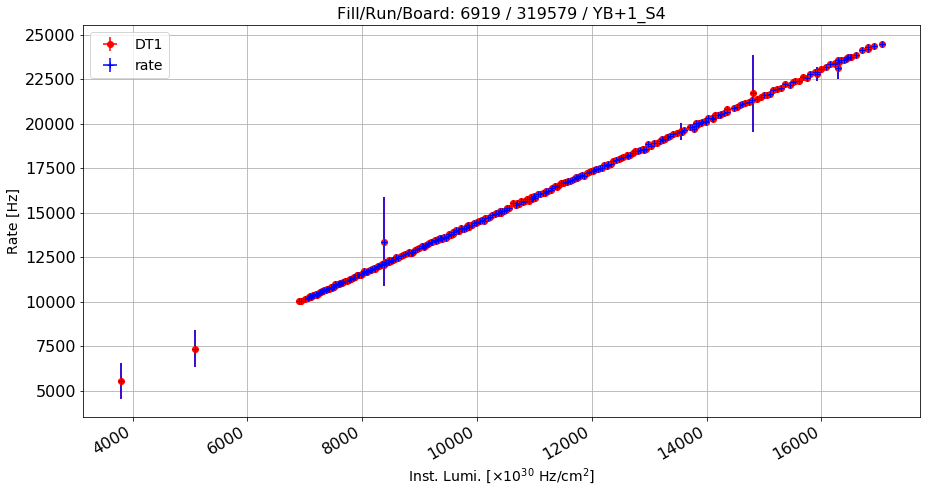

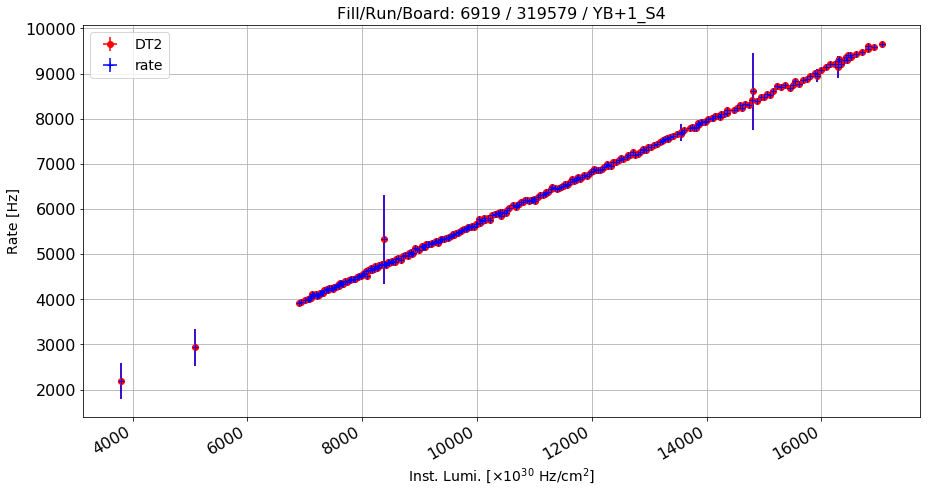

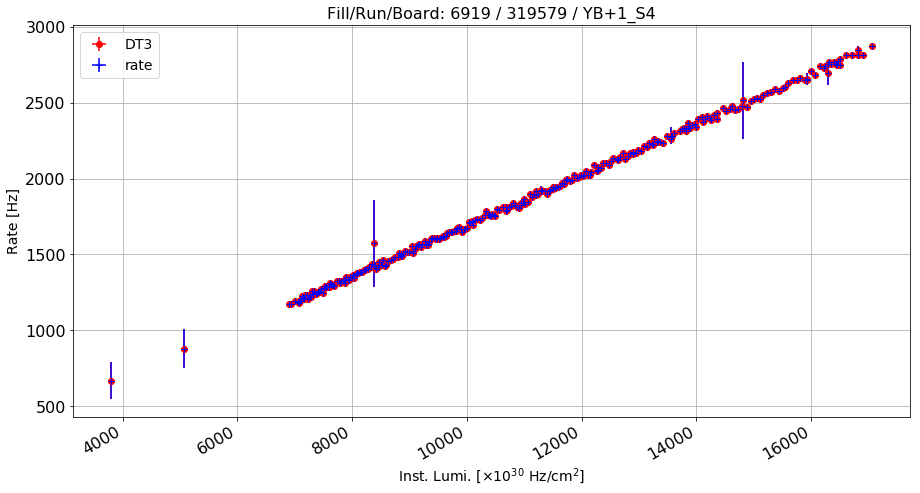

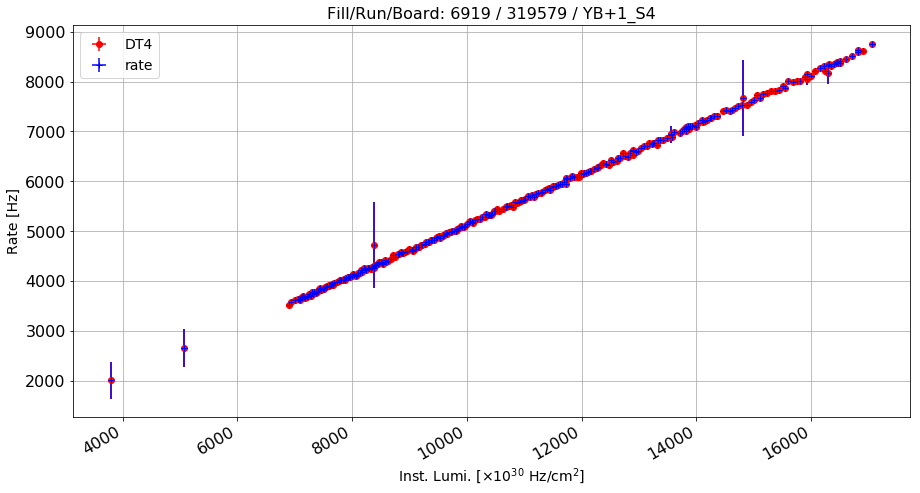

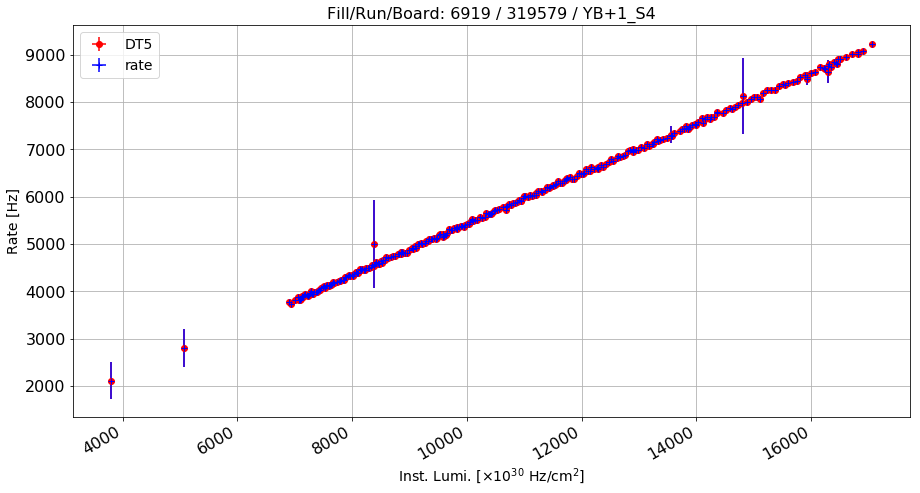

In [59]:
def plot_rate_vs_ls_2(df1, df2, x_val, y_val, x_err, y_err, title_x, title_y, title, opt):
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.errorbar(df1[x_val], df1[y_val], xerr=x_err, yerr=df1[y_err], fmt='ro', ecolor='r')
    num = y_val
    num = num.replace("DT", "")
    tmp = df2[df2.station == int(num)]
    plt.errorbar(tmp[x_val], tmp["rate"], xerr=x_err, yerr=tmp["err"], fmt='b+', ecolor='b')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

title = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+\
" / "+str(boundaries["run"].iloc[0])+" / YB+1_S4"

rule_1 = ((df_rates["wheel"] == 1) & (df_rates["sector"] == 4) & (df_rates["run"] == 319579))
rule_2 = ((df_rates_new_2["wheel"] == 1) & (df_rates_new_2["sector"] == 4)\
          & (df_rates_new_2["run"] == 319579))

temp1 = df_rates[rule_1]
temp2 = df_rates_new_2[rule_2]

plot_rate_vs_ls_2(temp1, temp2, "lumi", "DT1", 0, "errDT1", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "DT2", 0, "errDT2", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "DT3", 0, "errDT3", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "DT4", 0, "errDT4", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "DT5", 0, "errDT5", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")

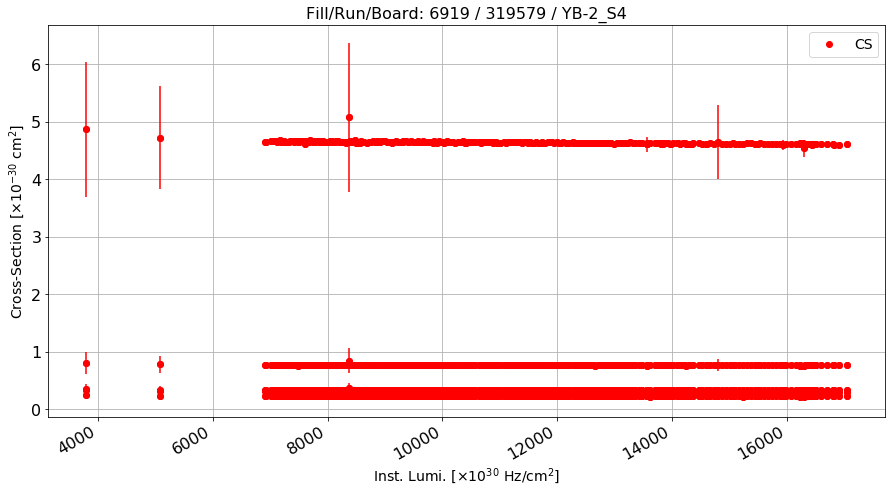

In [60]:
title = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[0])+" / YB-2_S4"

plot_rate_vs_ls(df_rates_new_2, 319579, "lumi", "CS", "YB-2_S4", 0, "errCS",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                r"Cross-Section [$\times10^{-30}$ cm$^{2}$]", title, "ro")

In [61]:
def plot_scatter_2(df, arg, wheel):
    wheel_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    else:
        return 1
    
    temp = temp.groupby(['run', 'board', 'wheel', 'sector', 'system', 'station'])\
    [[arg]].mean().reset_index()
    #print temp
    
    mat = []
    for i in [5, 4, 3, 2, 1]:
        rule = (temp.station == i)
        temp2 = temp[rule].sort_values(["sector"], ascending=True)
        vec = list(temp2[arg].values)
        if (i == 5):
            tmp = list(temp2[arg].values)
            vec = [0, 0, 0, tmp[0], 0, 0, 0, 0, 0, tmp[1], 0, 0]
        mat.append(vec)
        #print i, temp[rule][arg].values
    #print mat

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, round(mat[i][j], 2),\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Wheel: "+wheel_s
    plt.title(title, loc="right")   
    plt.show()

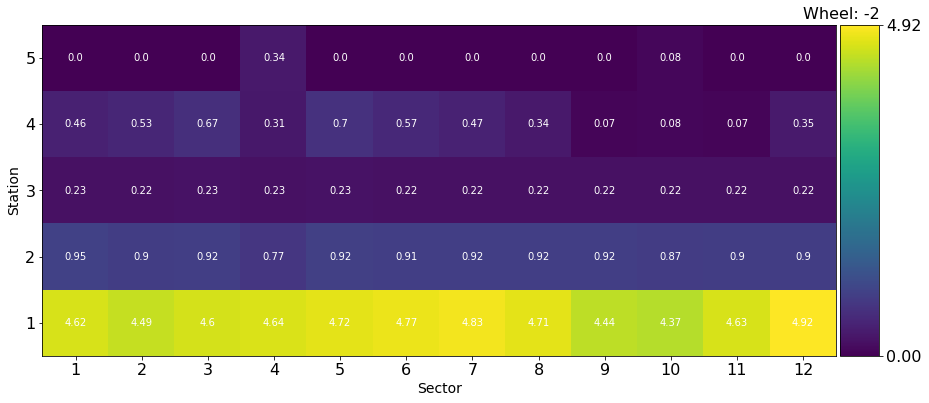

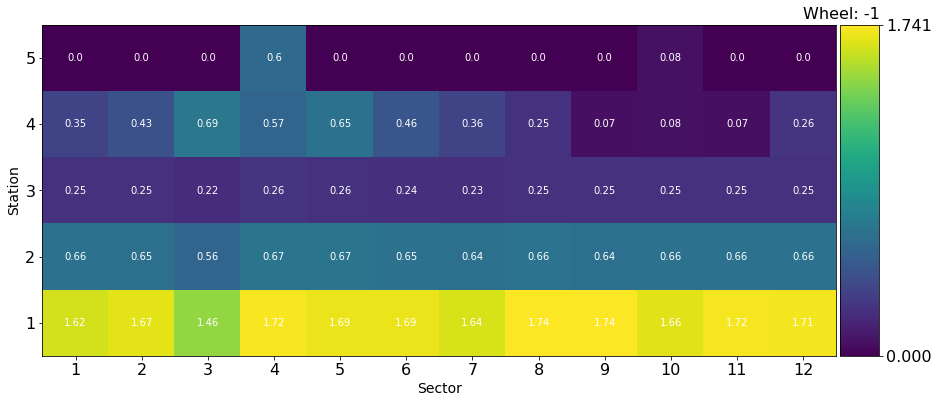

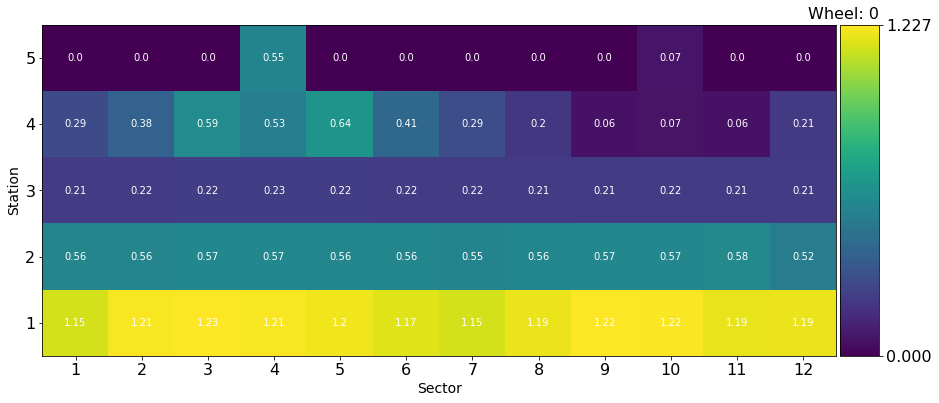

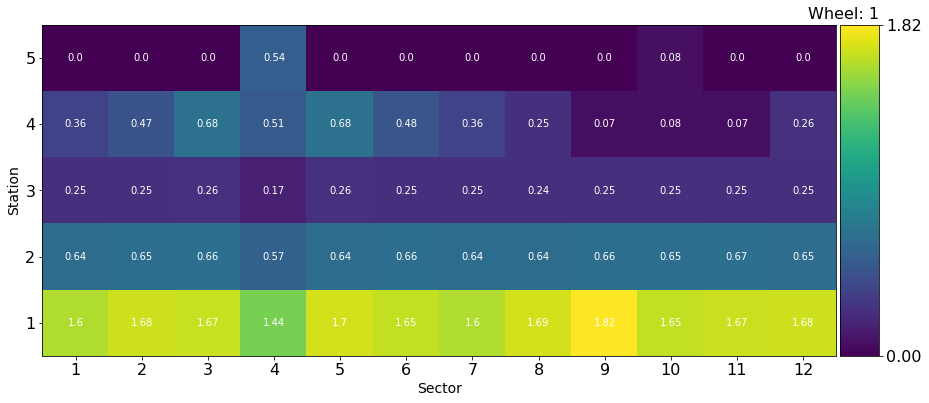

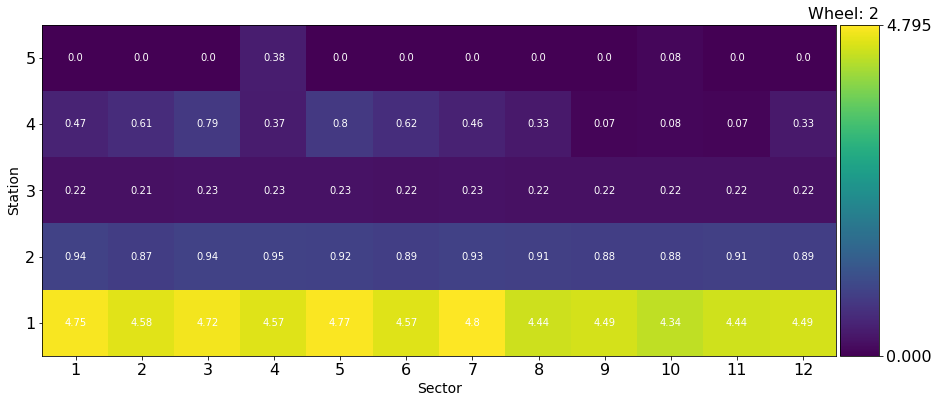

In [62]:
rule = (df_rates_new_2.lumi > 7000)
plot_scatter_2(df_rates_new_2[(df_rates_new_2.run == 319579) & rule], "CS", -2)
plot_scatter_2(df_rates_new_2[(df_rates_new_2.run == 319579) & rule], "CS", -1)
rule = (df_rates_new_2.lumi > 10000) #High rate for few LS before 10000
plot_scatter_2(df_rates_new_2[(df_rates_new_2.run == 319579) & rule], "CS", 0)
rule = (df_rates_new_2.lumi > 7000)
plot_scatter_2(df_rates_new_2[(df_rates_new_2.run == 319579) & rule], "CS", +1)
plot_scatter_2(df_rates_new_2[(df_rates_new_2.run == 319579) & rule], "CS", +2)

# Model training section <a class="anchor" id="fourth-bullet"></a>

## Creating train and test samples

In [63]:
df_rates_new = df_rates_new_2.copy()

In [64]:
print df_rates_new_2["content"].iloc[1]

[2 1 10 1 14806.156299999999 1535.8560523410895 25102.1 2330.542285248936
 1.6953826159460441 0.23601671898461296]


In [65]:
#To be run just one time!!!!!!
df_rates_new_2["content_in"] = df_rates_new_2["content"].copy()
def change_data(data):
    temp = data.copy()
    temp[2] = temp[2] - 6
    temp[3] = temp[3] - 3
    return temp

df_rates_new_2["content"] = df_rates_new_2["content"].apply(change_data)

In [66]:
print df_rates_new_2["content"].iloc[1]

[2 1 4 -2 14806.156299999999 1535.8560523410895 25102.1 2330.542285248936
 1.6953826159460441 0.23601671898461296]


In [67]:
anomalies = df_rates_new_2.copy()

In [68]:
normalies = anomalies.copy()

In [69]:
print len(normalies), len(anomalies)

96500 96500


In [70]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3) 
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2 -1 -3 0 14806.156299999999 1535.8560523410895 3306.0 308.7024097375623
 0.2232854991541593 0.03116353351378737]
Anomalous chimney:
[2 1 -2 0 14806.156299999999 1535.8560523410895 2516.4 253.97481064949028
 0.16995633093512597 0.024597637099220037]


In [71]:
def assignScore(df, score):
    temp = df.copy()
    rule = (temp["wheel"] == 1) & (temp["sector"] == 4) & (temp["station"] == 3)
    indexes = temp[rule].index
    #print indexes
    for i in indexes:
        temp.loc[i, "score"] = score
    return temp

temp = assignScore(anomalies, 1)
anomalies = temp

In [72]:
#rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
#print anomalies[rule]["score"]

Forcing the rate to the one of the symmetric chimney chamber:

In [73]:
def assignRate(df):
    rule1 = (df["wheel"] == 1) & (df["sector"] == 4) & (df["station"] == 3)# not good
    indexes1 = df[rule1].index
    #print indexes
    for i in indexes1:
        group = df.loc[i]["group"]
        run = df.loc[i]["run"]
        rule2 = (df["wheel"] == -1) & (df["sector"] == 3) & (df["station"] == 3) &\
            (df["group"] == group) & (df["run"] == run)
        indexes2 = (df[rule2].index) #it should contain one index
        #print i, index, time
        if(len(indexes2) > 0):
            j = indexes2[0]
            array = df.loc[j]["content"]
            rate = array[6] #good rate from the symmetric sector
            err = array[7] #uncertainty on the good rate from the symmetric sector
            CS = array[8]
            errCS = array[9]
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[6] = rate
            content[7] = err
            content[8] = CS
            content[9] = errCS
            df.loc[i, "rate"] = rate
            df.loc[i, "err"] = err
            df.loc[i, "CS"] = CS
            df.loc[i, "errCS"] = errCS
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content
        else:
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[6] = -1
            content[7] = -1
            content[8] = -1
            content[9] = -1
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content

assignRate(normalies)

Check that the change affects only normalies:

In [74]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3)
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2 -1 -3 0 14806.156299999999 1535.8560523410895 3306.0 308.7024097375623
 0.2232854991541593 0.03116353351378737]
Anomalous chimney:
[2, 1, -2, 0, 14806.156299999999, 1535.8560523410895, 3306.0, 308.7024097375623, 0.2232854991541593, 0.03116353351378737]


In [75]:
rule = (anomalies["wheel"] == -1) & (anomalies["sector"] == 3) & (anomalies["station"] == 3)
print "Normal chimney:"
print anomalies[rule]["content"].iloc[0]

rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
print "Anomalous chimney:"
print anomalies[rule]["content"].iloc[0]

Normal chimney:
[2 -1 -3 0 14806.156299999999 1535.8560523410895 3306.0 308.7024097375623
 0.2232854991541593 0.03116353351378737]
Anomalous chimney:
[2 1 -2 0 14806.156299999999 1535.8560523410895 2516.4 253.97481064949028
 0.16995633093512597 0.024597637099220037]


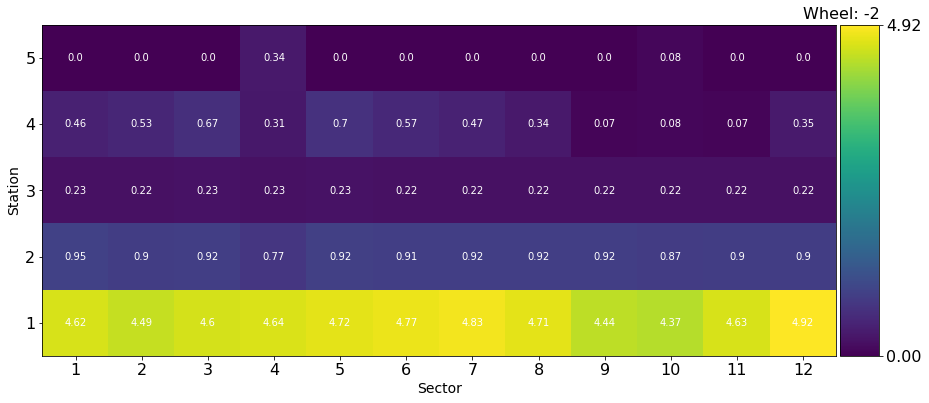

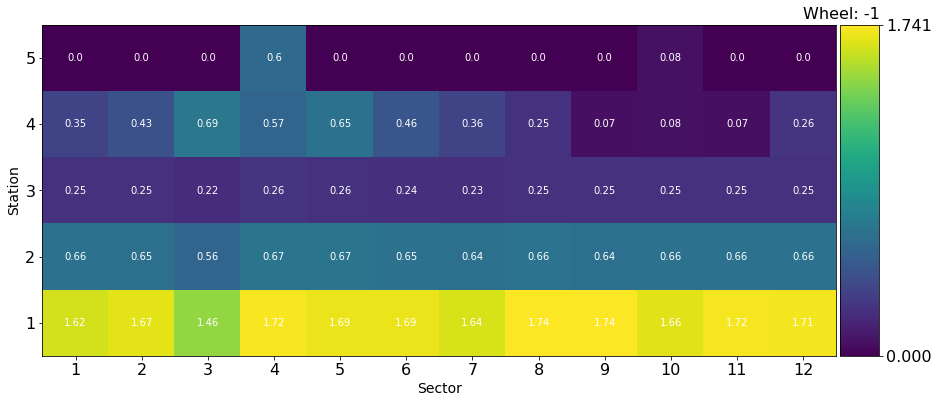

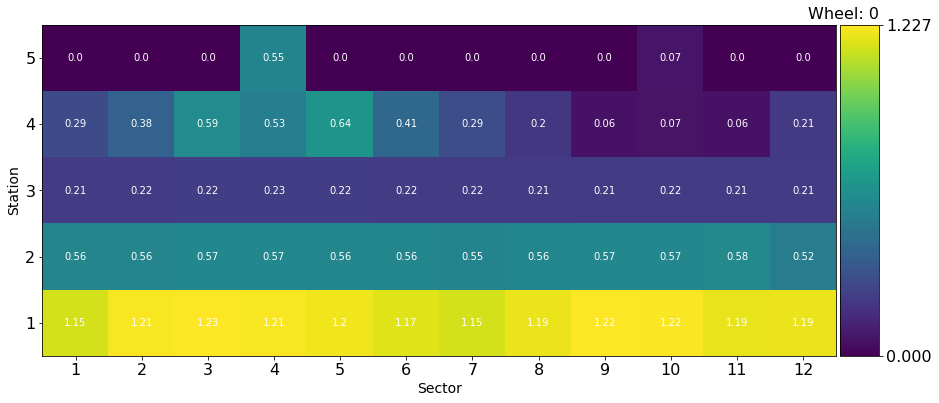

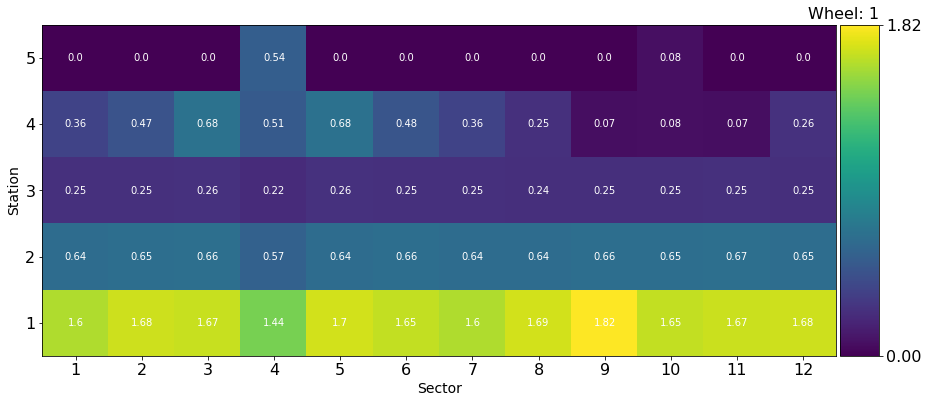

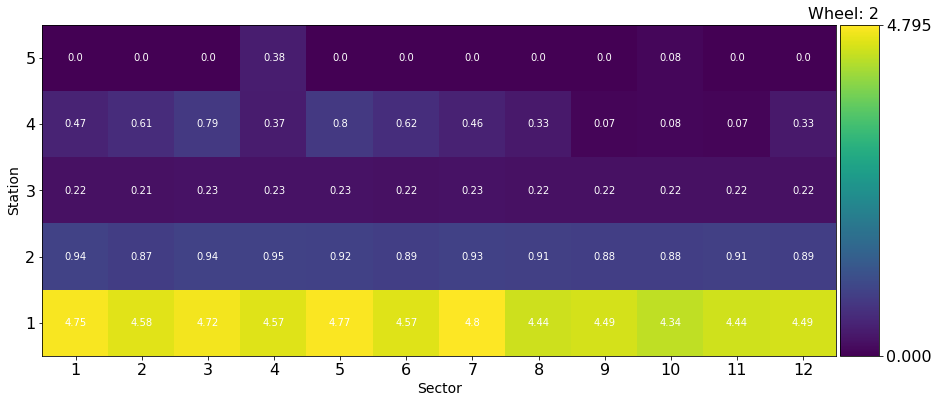

In [76]:
rule = (normalies.lumi > 7000)
plot_scatter_2(normalies[(normalies.run == 319579) & rule], "CS", -2)
plot_scatter_2(normalies[(normalies.run == 319579) & rule], "CS", -1)
rule = (normalies.lumi > 10000)
plot_scatter_2(normalies[(normalies.run == 319579) & rule], "CS", 0)
rule = (normalies.lumi > 7000)
plot_scatter_2(normalies[(normalies.run == 319579) & rule], "CS", +1)
plot_scatter_2(normalies[(normalies.run == 319579) & rule], "CS", +2)

In [77]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
def scale_data(data, scaler_type = 2):
    
    types = ["RobustScaler", "MaxAbsScaler", "QuantileTransformerUniform",\
             "QuantileTransformerNormal", "Normalizer", "MinMaxScaler"]
    #print "Scaling data using:", types[scaler_type-1]
    
    # Need to reshape since scaler works per column

    if (scaler_type == 0):
        return data
    if (scaler_type == 1):
        data = data.reshape(-1, 1)
        scaler = RobustScaler(quantile_range=(25, 75)).fit(data)
        return scaler.transform(data).reshape(1, -1)
    if (scaler_type == 2):
        data = data.reshape(-1, 1)
        scaler = MaxAbsScaler().fit(data)
        return scaler.transform(data).reshape(1, -1)
    if (scaler_type == 3):
        data = data.reshape(-1, 1)
        scaler = QuantileTransformer(output_distribution='uniform').fit(data)
        return scaler.transform(data).reshape(1, -1)
    if (scaler_type == 4):
        data = data.reshape(-1, 1)
        scaler = QuantileTransformer(output_distribution='normal').fit(data)
        return scaler.transform(data).reshape(1, -1)
    if (scaler_type == 5):
        data = data.reshape(1, -1)
        scaler = Normalizer(norm='l2').fit_transform(data)
        return scaler.reshape(1, -1)
    if (scaler_type == 6):
        data = data.reshape(-1, 1)
        scaler = MinMaxScaler().fit(data)
        return scaler.transform(data).reshape(1, -1)

In [78]:
anomalies["content"] = anomalies["content"].apply(np.array)
anomalies["content_scaled"] = anomalies["content"].apply(scale_data)

normalies["content"] = normalies["content"].apply(np.array)
normalies["content_scaled"] = normalies["content"].apply(scale_data)

In [79]:
#print anomalies["content_scaled"]
#print normalies["content_scaled"]

In [80]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)
anomalies = anomalies[(anomalies.score == 1) & (anomalies.run != 321312)]
normalies = normalies[(normalies.score == -1) & (normalies.run != 321312)]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train,\
                                                                test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train,\
                                                                test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

313 faults and 78250 good samples. In total: 78563.


In [81]:
print("Number of anomalies in the train set: %s" % len(anomalies_train))
print("Number of normal in the train set: %s" % len(normalies_train))
print("Number of anomalies in the test set: %s" % len(anomalies_test))
print("Number of normal in the test set: %s" % len(normalies_test))

Number of anomalies in the train set: 250
Number of normal in the train set: 62600
Number of anomalies in the test set: 63
Number of normal in the test set: 15650


In [82]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0]) #Normaly
    return np.asarray([0, 1]) #Anomaly

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 10))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

In [83]:
def cae_generate_input():
    return np.array(np.concatenate(normalies.content_scaled.values)).reshape(-1, 10)

train_cae = cae_generate_input()

In [84]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}
print cw

{0: 0.5019968051118211, 1: 125.7}


## Simple test

In [85]:
cross_sections = pd.DataFrame(columns=["wheel", "sector", "station", "CS", "errCS"])
def extract_cs(df, cross_sections):
    for i in [-2, -1, 0, +1, +2]:
        for j in range(1, 13):
            range_ = range(1, 5)
            if ((j == 4) | (j == 10)):
                range_ = range(1, 6)
            for k in range_:
                rule = ((df.wheel  == i) & (df.sector == j) &\
                        (df.station == k))
                val1 = df[rule]["lumi"]
                val2 = df[rule]["CS"]
                fit, cov = np.polyfit(val1, val2, 0, cov=True)
                err = np.sqrt(np.diag(cov))
                cross_sections = cross_sections.append({"wheel": i, "sector": j, "station": k,\
                                                        "CS": float(fit), "errCS": float(err)},\
                                                       ignore_index = True)
    return cross_sections

In [86]:
cross_sections = extract_cs(normalies_train[normalies_train.lumi > 10000], cross_sections)

In [87]:
print cross_sections[(cross_sections.wheel == +2) & (cross_sections.sector == 10) &\
                     (cross_sections.station == 3)]["CS"]
print cross_sections[(cross_sections.wheel == +2) & (cross_sections.sector == 10) &\
                     (cross_sections.station == 4)]["CS"]

239    0.218224
Name: CS, dtype: float64
240    0.075708
Name: CS, dtype: float64


In [88]:
def simple_test(cross_sections, df, coeff):
    for i in df.index:
        wheel = df.wheel.loc[i]
        sector = df.sector.loc[i]
        station = df.station.loc[i]
        cs = df.CS.loc[i]
        err_cs = df.errCS.loc[i]
        #print cs
        rule = ((cross_sections.wheel == wheel) & (cross_sections.sector == sector) &\
                (cross_sections.station == station))
        cs_norm = cross_sections[rule].CS.iloc[0]
        err_cs_norm = cross_sections[rule].errCS.iloc[0]
        #low = cs_norm - coeff*err_cs_norm
        #hi = cs_norm + coeff*err_cs_norm
        delta = abs(cs_norm - cs) / cs_norm
        #low = cs_norm*(1 - coeff)
        #hi = cs_norm*(1 + coeff)
        #print low, hi
        #if ((cs > low) & (cs < hi)):
        #    res = 0
        #else:
        #    res = +1
        df.loc[i, "st_score"] = delta

In [89]:
layers_test["st_score"] = 0
layers_test.index = pd.RangeIndex(len(layers_test.index))
simple_test(cross_sections, layers_test, 0.05)

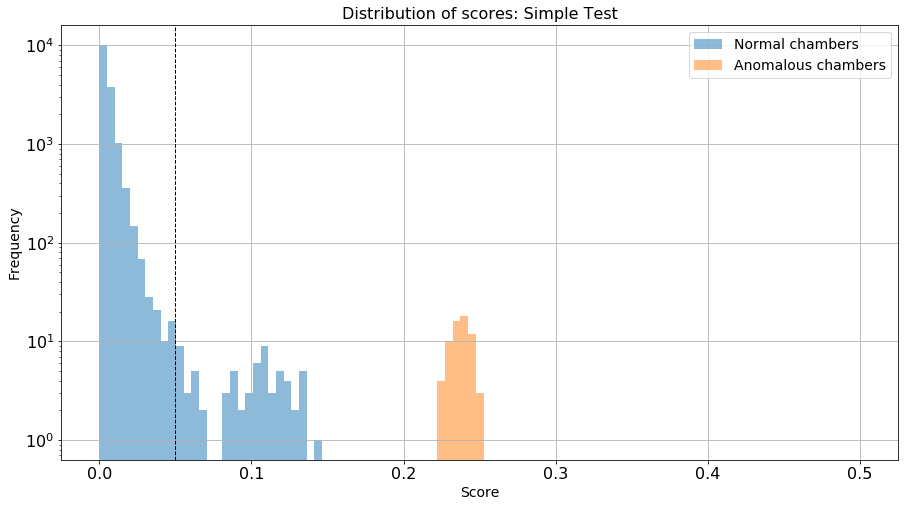

In [90]:
# Distribution of scores:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.5, 100)
plt.hist(layers_test[layers_test["score"] < 0]["st_score"], bins=bins, alpha=0.5,\
         label="Normal chambers")
plt.hist(layers_test[layers_test["score"] > 0]["st_score"], bins=bins, alpha=0.5,\
         label="Anomalous chambers")
plt.title("Distribution of scores: Simple Test")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)
plt.show()

In [91]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.99559105  0.00440895]
 [ 0.          1.        ]]


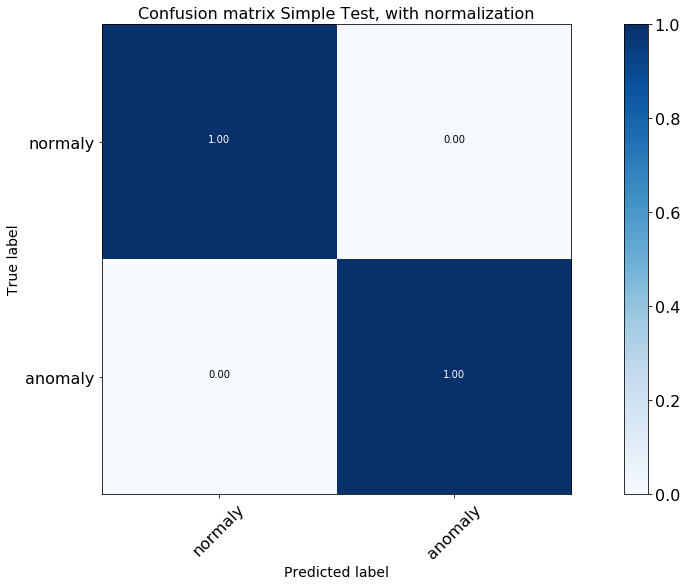

In [92]:
th_km = 0.05
y_pred = 2*(layers_test["st_score"] > th_km)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix Simple Test, with normalization')

## NN architectures

Setting the enviroment and defining some useful functions:

In [93]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
K.set_session(sess)

In [94]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    ax.grid()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])
        #plt.xlim(0, 0.2)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="DNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show();

In [95]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    y_true = 2*(y_true > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity

In [96]:
def count_fp(df, dis_nn, th, filt):
    df_temp = df[(layers_test["score"] == -1) & (layers_test[dis_nn] > th)].copy()
    df_temp = df_temp.groupby(['run', 'wheel', 'sector', 'station', 'name'])\
    .size().reset_index(name='counts')
    if filt:
        df_temp = df_temp[df_temp["counts"] > 1]
    #print df_temp
    return len(df_temp), df_temp

In [97]:
def get_matrix(df):
    x = np.zeros((5,12),dtype=int)
    for i in range(len(df)):
        a = int(5-df["station"].iloc[i])
        b = int(df["sector"].iloc[i]-1)
        x[a,b] = x[a,b] + 1
    return x

def deduceLS(data):
    return data*10+5
layers_test["averageLS"] = layers_test["group"].apply(deduceLS)

In [98]:
def plot_scatter(df, run, wheel, ls_min, ls_max):
    run_s = "All"
    wheel_s = "All"
    ls_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    if run != -1:
        temp = temp[(temp["run"] == run)]
        run_s = str(run)
    if ((ls_min != -1) & (ls_max == -1)):
        temp = temp[(temp["averageLS"] >= ls_min)]
        ls_s = "> "+str(ls_min)
    elif ((ls_min == -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] <= ls_max)]
        ls_s = "< "+str(ls_max)
    elif ((ls_min != -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] >= ls_min) & (temp["averageLS"] <= ls_max)]
        ls_s = " ["+str(ls_min)+", "+str(ls_max)+"]"
    mat = get_matrix(temp)
    print mat
    print mat.sum()

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, mat[i, j],\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Run: "+run_s+", Wheel: "+wheel_s+", LS: "+ls_s
    plt.title(title, loc="right")   
    plt.show()

In [99]:
def plotFpVsLs(run, wheel, sector, station, title, df, algo, threshold, log, bound):
    fig, ax = plt.subplots()
    if log:
        ax.set_yscale('log')
    bins = np.linspace(0, bound, int(bound/10)+10)
    (n, bins, patches) = plt.hist(df[(df["score"] == -1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, alpha=0.5, label="False positives")
    plt.hist(df[(df["score"] == 1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, alpha=0.5, label="True positives")
    plt.plot(df[(df["run"] == run)]["averageLS"],\
             df[(df["run"] == run)]["lumi"], "ro",\
             alpha=0.5, label="Inst. Lumi. $(x 10^{30} Hz/cm^2)$")
    plt.title(title+str(run))
    plt.legend(loc='best')
    plt.ylabel('Frequency')
    plt.xlabel('LS')
    plt.grid(True)
    #plt.plot([bound, bound], [0, 100], color='r', linestyle='--', linewidth=2)
    plt.show()
    return n

Trying KMeans clustering algorithm. First of all let's find the optimal number of clusters (parameter to the algorithm) by scanning the average distance vs. number of clusters:

In [100]:
means = []
for i in range(1, 300, 10):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291


In [101]:
for i in range(300, 500, 10):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [102]:
for i in range(500, 1000, 100):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

500
600
700
800
900


In [103]:
for i in range(1000, 2000, 200):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

1000
1200
1400
1600
1800


In [104]:
for i in range(2, 10, 1):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

2
3
4
5
6
7
8
9


In [105]:
def getKey(item):
    return item[0]

means = sorted(means, key=getKey)

In [106]:
der = []
for i in range(0, len(means)-1):
    x, y = zip(*means)
    a = np.sqrt(y[i]/len(normalies_train))
    b = np.sqrt(y[i+1]/len(normalies_train))
    delta = (a-b)/a
    der.append([x[i], delta])

In [107]:
rel = []
for i in range(0, len(means)-1):
    x, y = zip(*means)
    a = np.sqrt(y[i]/len(normalies_train))
    b = np.sqrt(y[i+1]/len(normalies_train))
    delta = (a-b)*100000/y[0]
    rel.append([x[i], delta])

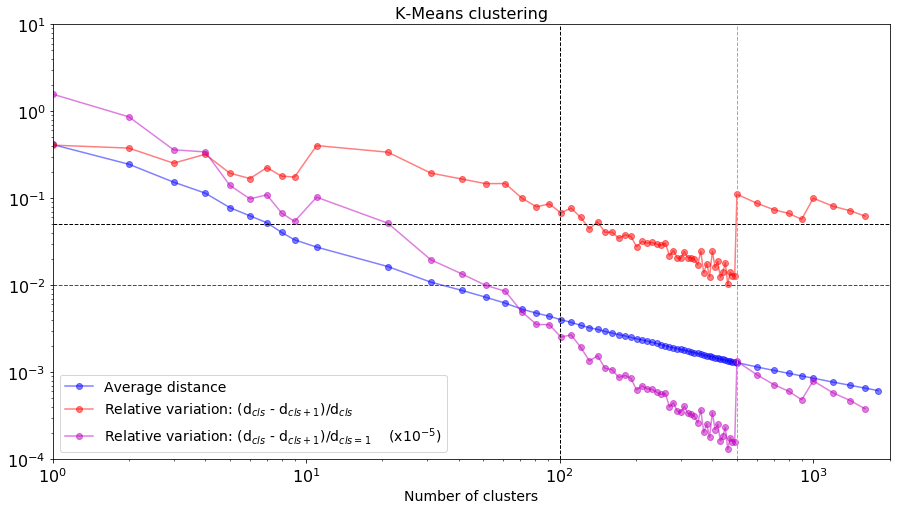

In [108]:
def plotDist(means, der, rel):
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.set_xscale('log')
    x, y = zip(*means)
    a, b = zip(*der)
    c, d = zip(*rel)
    plt.ylim(0.0001, 10.)
    plt.xlim(1, 2000)
    plt.plot(x, np.sqrt(np.array(y)/len(normalies_train)), "bo-", alpha=0.5, label="Average distance")
    plt.plot(a, b, "ro-", alpha=0.5, label = "Relative variation: (d$_{cls}$ - d$_{cls+1}$)/d$_{cls}$")
    plt.plot(c, d, "mo-", alpha=0.5, label = "Relative variation: (d$_{cls}$ - d$_{cls+1}$)/d$_{cls = 1}$\
    (x$10^{-5}$)")
    plt.axhline(0.05, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0.01, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(100, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(500, color='y', linestyle='dashed', linewidth=1)
    plt.title("K-Means clustering")
    plt.legend(loc='best')
    #plt.ylabel('Inertia')
    plt.xlabel('Number of clusters')
    plt.show()
    
plotDist(means, der, rel)

Choosing 450 clusters and training on the normalies only:

In [109]:
n_cls = 450
k_means = cluster.KMeans(n_clusters=n_cls)

norm = layers_train[layers_train.score == -1].copy()
distances = k_means.fit_transform(np.vstack(norm["content_scaled"].values))
norm["kmeans_score"] = k_means.labels_

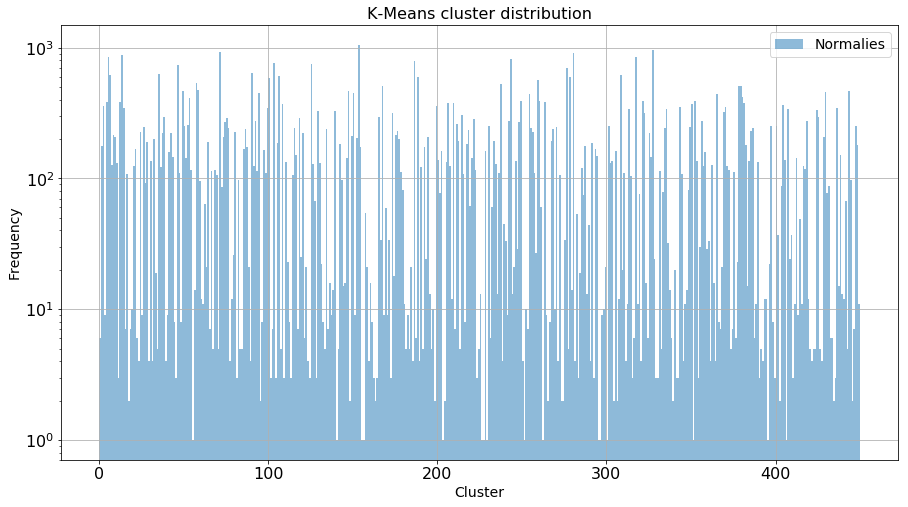

In [110]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, n_cls, n_cls+1)
plt.hist(norm[norm["score"] < 0]["kmeans_score"], bins=bins, alpha=0.5, label="Normalies")
plt.title("K-Means cluster distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Cluster')
plt.show()

The minimal distance is used to assign the data to the clusters. Visualize the average distance within a cluster:

In [111]:
minim = []
for i in range(0, len(distances)):
    #print  min(distances[i])
    minim.append(min(distances[i]))

In [112]:
#print len(minim)
norm["dist"] = minim
#print norm["dist"]

In [113]:
temp1 = norm.groupby(["kmeans_score"])[["dist"]].mean().reset_index()        

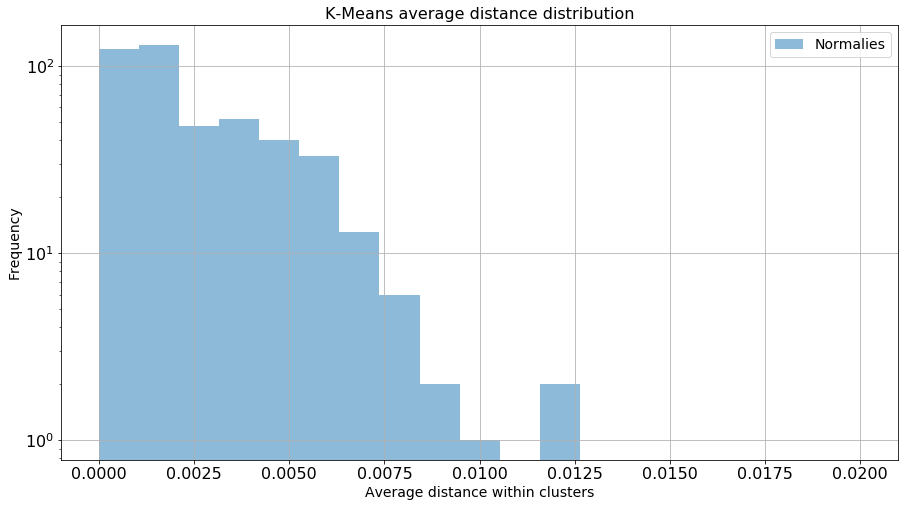

In [114]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.02, 20)
plt.hist(temp1["dist"], bins=bins, alpha=0.5, label="Normalies")
plt.title("K-Means average distance distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Average distance within clusters')
plt.show()

Predicting the distances of the test sample data with respect to the clusters and plotting the minimum distance for each point (dividing anomalies and normalies):

In [115]:
distances_test = k_means.transform(np.vstack(layers_test["content_scaled"].values))
minim = []
for i in range(0, len(distances_test)):
    #print  min(distances_test[i])
    minim.append(min(distances_test[i]))
layers_test["dist"] = minim

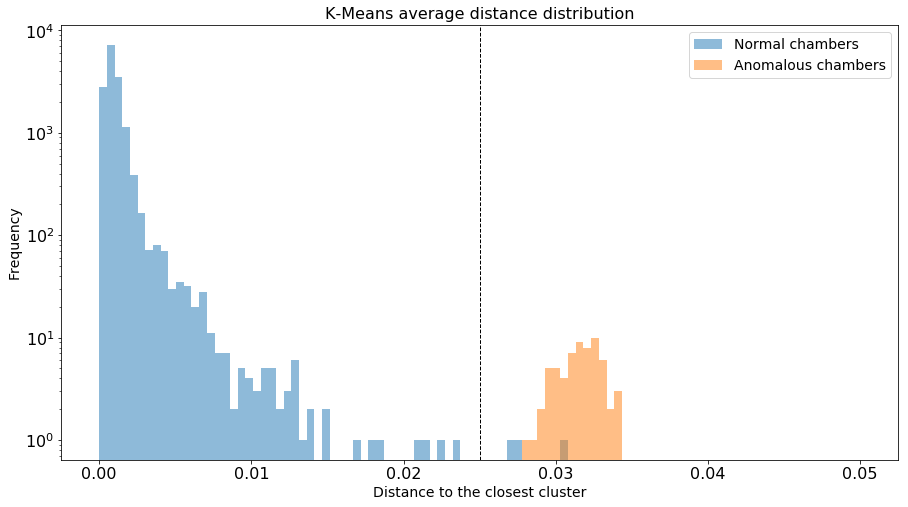

In [116]:
fig, ax = plt.subplots()
ax.set_yscale('log')
#ax.grid()
bins = np.linspace(0, 0.05, 100)
plt.hist(layers_test[layers_test["score"] < 0]["dist"], bins=bins, alpha=0.5, label="Normal chambers")
plt.hist(layers_test[layers_test["score"] > 0]["dist"], bins=bins, alpha=0.5, label="Anomalous chambers")
plt.axvline(0.025, color='k', linestyle='dashed', linewidth=1)
plt.title("K-Means average distance distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Distance to the closest cluster')
plt.show()

Normalized confusion matrix
[[  9.99808307e-01   1.91693291e-04]
 [  0.00000000e+00   1.00000000e+00]]


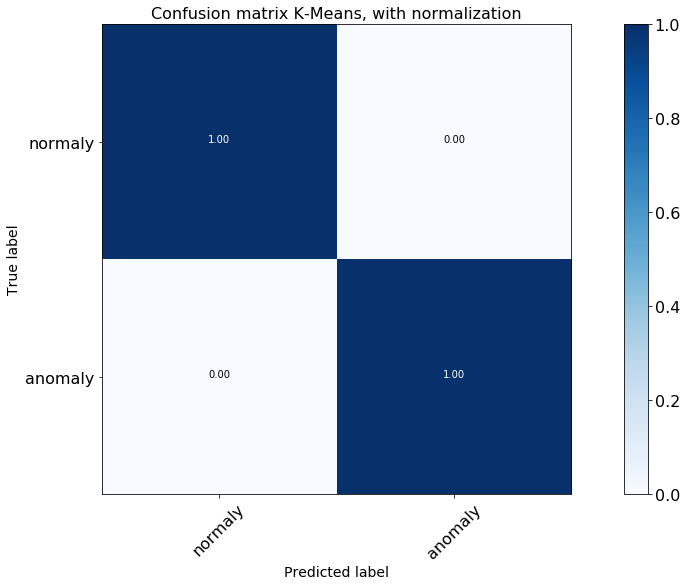

In [117]:
th_km = 0.025
y_pred = 2*(layers_test["dist"] > th_km)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix K-Means, with normalization')

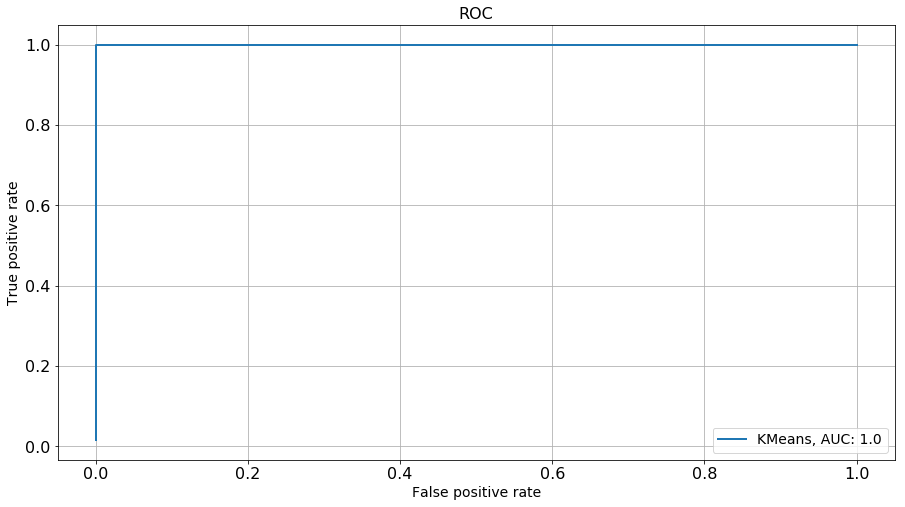

In [118]:
get_roc_curve(layers_test,[
                           #("Variance", "variance_score"),
                           #("IF", "if_score"),
                           #("SVM", "svm_score"),
                           #("AE", "cae_score"),
                           ("KMeans", "dist"),
                           #("DNN", "ann_score_4"),
                          ]
             )

In [119]:
filename = './model_sktlearn/kmeans_all_2018.sav'
joblib.dump(k_means, filename)

['./model_sktlearn/kmeans_all_2018.sav']

## Reducing features

Still KMeans but reducing the number of features. Removing lumi, rate and errors: 

In [120]:
# 0.system, 1.wheel, 2.sector, 3.station, 4.lumi, 5.err, 6.rate, 7.err, 8.CS, 9.err
def removeItem(data):
    index = [0, 4, 5, 6, 7, 9] #leaving only position and CS
    #index = [0, 5, 7, 9] #removing system and errors
    temp = data.copy()
    temp = np.delete(temp, index)
    return temp

layers_test["content"] = layers_test["content"].apply(np.array)
layers_test["content_red"] = layers_test["content"].apply(removeItem)
layers_test["content_red"] = layers_test["content_red"].apply(np.array)

layers_train["content"] = layers_train["content"].apply(np.array)
layers_train["content_red"] = layers_train["content"].apply(removeItem)
layers_train["content_red"] = layers_train["content_red"].apply(np.array)

Determine the average cross-section for every chamber during a normal run and save the one from station 1:

In [121]:
values = []
for i in [-2, -1, 0, +1, +2]:
    v_temp = []
    for j in range(1, 13):
        temp = cross_sections[(cross_sections.wheel == i) &\
                            (cross_sections.sector == j)].copy()
        #print temp
        v_temp.append(temp["CS"].iloc[0])
        #print i, j, temp["CS"].iloc[0]
    values.append(v_temp)

Calculating scale factors to normalize the CS to 5 in all the chambers:

In [122]:
factors = layers_train[(layers_train.score == -1) & (layers_train.lumi > 10000)].\
groupby(['wheel', 'sector', 'station'])\
["CS"].mean().reset_index()
factors["factor"] = factors["CS"].copy()

def scale_cs_for_sf(df):
    for i in [-2, -1, 0, +1, +2]:
        for j in range(1, 13):
            for k in range(1, 6):
                rule = (df.wheel == i) & (df.sector == j) & (df.station == k)
                indexes = df[rule].index
                if (len(indexes) == 0):
                    continue            
                for m in indexes:
                  df.loc[m, "factor"] = 6/df.loc[m, "CS"]

In [123]:
scale_cs_for_sf(factors)

In [124]:
print factors[(factors.wheel == +1) & (factors.sector == 4) & (factors.station == 3)]
print factors[(factors.wheel == +2) & (factors.sector == 10) & (factors.station == 3)]

     wheel  sector  station        CS     factor
164      1       4        3  0.221515  27.086168
     wheel  sector  station        CS     factor
239      2      10        3  0.218224  27.494745


In [125]:
factors.to_csv("factors_2018.csv", sep=',', header=False)

Multiplying the cross-section values by the factors previously determined:

In [126]:
#Reindex because otherwise anomalies and normalies have the same labels/indexes in W+3_S4_MB3
layers_train.index = pd.RangeIndex(len(layers_train.index))
layers_test.index = pd.RangeIndex(len(layers_test.index))

def scale_cs(df, factors):
    for i in [-2, -1, 0, +1, +2]:
        for j in range(1, 13):
             for k in range(1, 6):
                rule = (df.wheel == i) & (df.sector == j) & (df.station == k)
                rule_f = (factors.wheel == i) & (factors.sector == j) & (factors.station == k)
                indexes = df[rule].index
                indexes_f = (factors[rule_f].index)
                if ((len(indexes) == 0) | (len(indexes_f) == 0)):
                    continue
                #print factors.loc[indexes_f[0], "factor"]
                for m in indexes:
                    #print i, j, k, m, df.loc[m, "content_red"]
                    content =  df.loc[m, "content_red"].copy()
                    #print i, j, k, m, df.loc[m, "content_red"], content
                    content[3] = content[3]*factors.loc[indexes_f[0], "factor"]
                    #print i, j, k, m, df.loc[m, "content_red"], content
                    df.at[m, "content_red"] = content

scale_cs(layers_train, factors)
scale_cs(layers_test, factors)

In [127]:
#0.No rescaling
#1.RobustScaler
#2.MaxAbsScaler 
#3.QuantileTransformerUniform: NO
#4.QuantileTransformerNormal: NO
#5.Normalizer
#6.MinMaxScaler

scaler_type = 5
layers_test["content_red_scaled"] = layers_test["content_red"].apply(scale_data, args=[scaler_type])
layers_train["content_red_scaled"] = layers_train["content_red"].apply(scale_data, args=[scaler_type])

Extracting CS from the feature vector and plotting the scaled CS:

In [128]:
def extract_cs(data):
    #print data[0][3]
    return data[3]
    #return data[0][3]

layers_train["CS_red"] = layers_train["content_red"].apply(extract_cs)
layers_test["CS_red"] = layers_test["content_red"].apply(extract_cs)

#layers_train["CS_red"] = layers_train["content_red_scaled"].apply(extract_cs)
#layers_test["CS_red"] = layers_test["content_red_scaled"].apply(extract_cs)

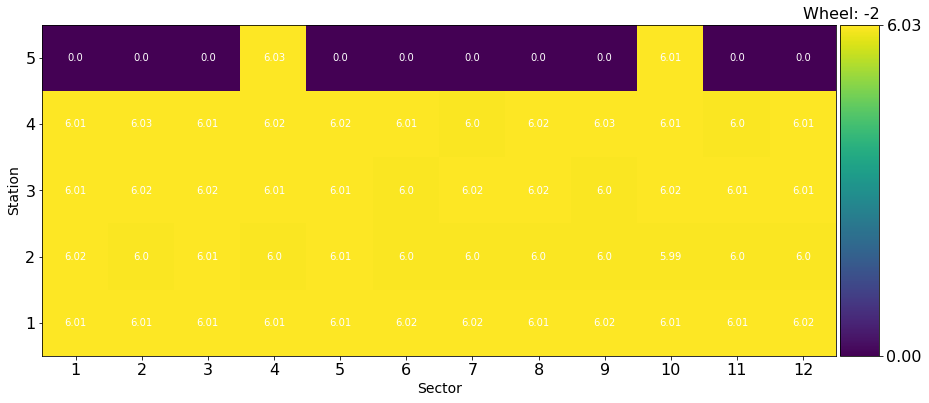

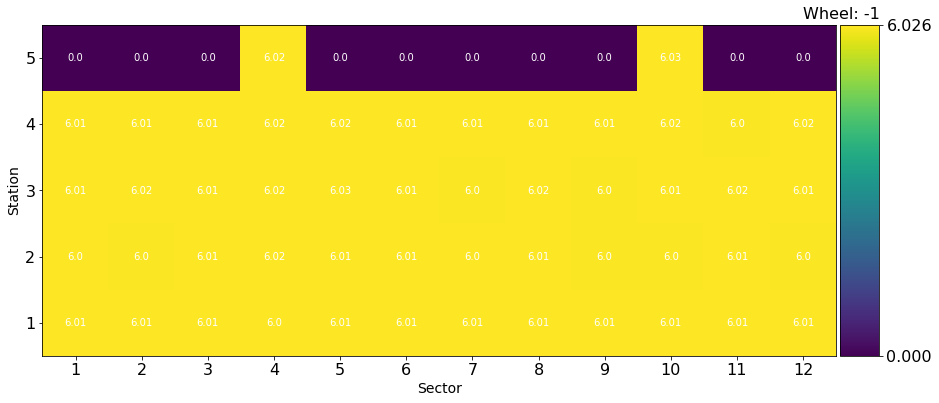

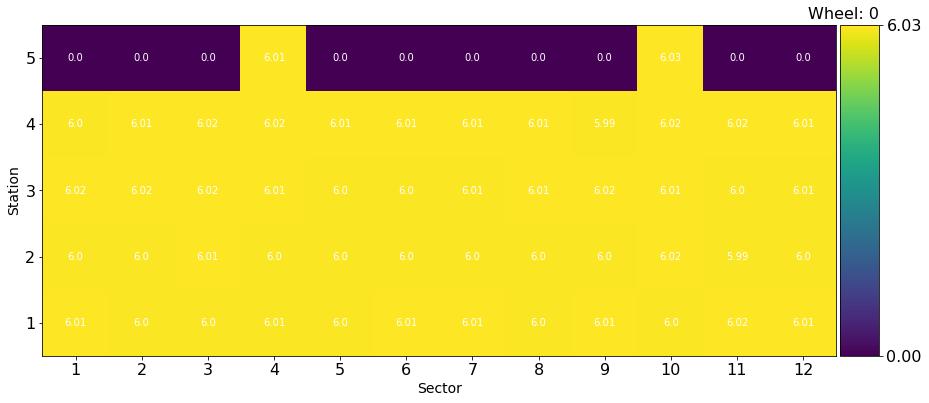

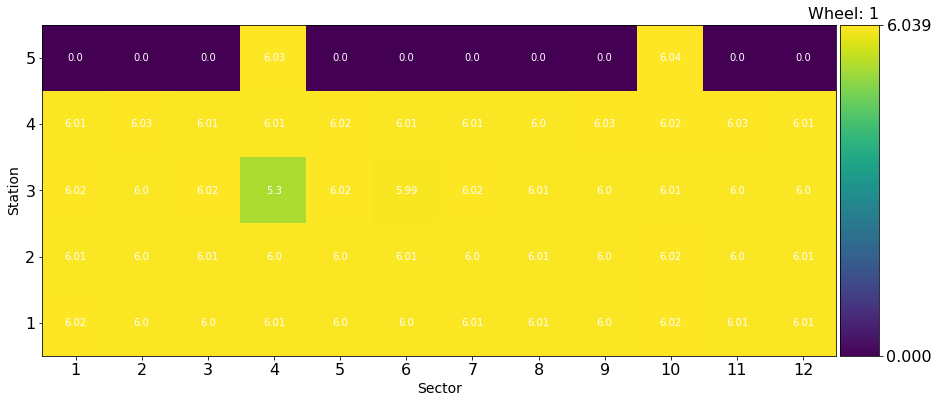

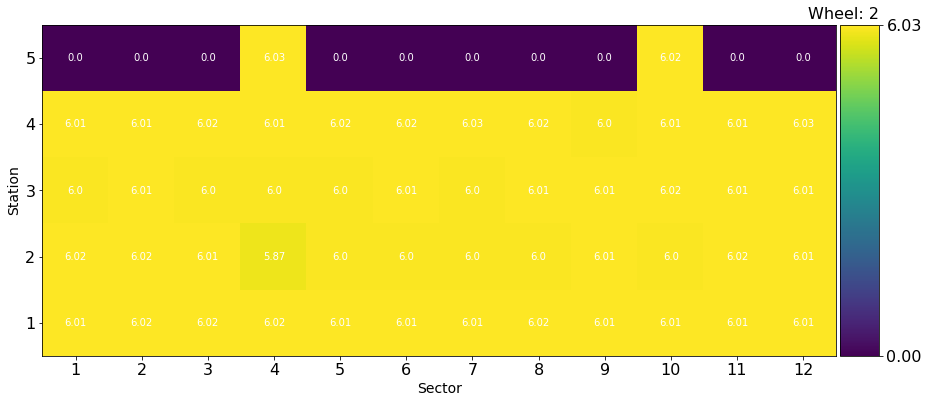

In [129]:
plot_scatter_2(layers_test[layers_test.run == 319579], "CS_red", -2)
plot_scatter_2(layers_test[layers_test.run == 319579], "CS_red", -1)
plot_scatter_2(layers_test[layers_test.run == 319579], "CS_red", 0)
plot_scatter_2(layers_test[layers_test.run == 319579], "CS_red", +1)
plot_scatter_2(layers_test[layers_test.run == 319579], "CS_red", +2)

In [130]:
print layers_train["content_red"].iloc[1]
print layers_train["content_red_scaled"].iloc[1]
print layers_test["content_red"].iloc[1]
print layers_test["content_red_scaled"].iloc[1]

[1 -2 0 4.552869226753355]
[[ 0.19714772 -0.39429545  0.          0.89758781]]
[1 -2 0 4.612344967604586]
[[ 0.19509187 -0.39018373  0.          0.89983099]]


In [131]:
norm = layers_train[layers_train.score == -1].copy()
#norm = norm[norm.run == 306125]

In [132]:
n_cls = 450
k_means_red = cluster.KMeans(n_clusters=n_cls)
distances_red = k_means_red.fit_transform(np.vstack(norm["content_red"].values))
norm["kmeans_red_score"] = k_means_red.labels_

In [133]:
minim = []
for i in range(0, len(distances_red)):
    #print  min(distances_red[i])
    minim.append(min(distances_red[i]))

In [134]:
#print len(minim)
norm["dist_red"] = minim
#print norm["dist_red"]

In [135]:
temp1 = norm.groupby(["kmeans_red_score"])[["dist_red"]].mean().reset_index()

In [136]:
distances_test_red = k_means_red.transform(np.vstack(layers_test["content_red"].values))
minim = []
for i in range(0, len(distances_test_red)):
    #print  min(distances_test_red[i])
    minim.append(min(distances_test_red[i]))
layers_test["dist_red"] = minim

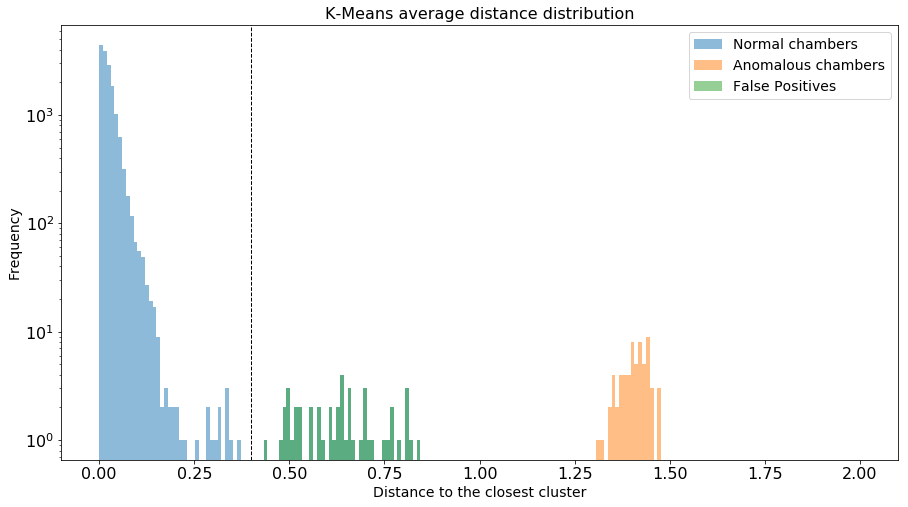

In [137]:
th_km = 0.4

fig, ax = plt.subplots()
ax.set_yscale('log')
#ax.grid()
bins = np.linspace(0, 2.0, 200)
rule = (layers_test.dist_red > th_km)
plt.hist(layers_test[layers_test["score"] < 0]["dist_red"], bins=bins,\
         alpha=0.5, label="Normal chambers")
plt.hist(layers_test[layers_test["score"] > 0]["dist_red"], bins=bins,\
         alpha=0.5, label="Anomalous chambers")
plt.hist(layers_test[(layers_test["score"] < 0) & rule]["dist_red"], bins=bins,\
         alpha=0.5, label="False Positives")
plt.axvline(0.4, color='k', linestyle='dashed', linewidth=1)
plt.title("K-Means average distance distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Distance to the closest cluster')
plt.show()

Normalized confusion matrix
[[ 0.99699681  0.00300319]
 [ 0.          1.        ]]


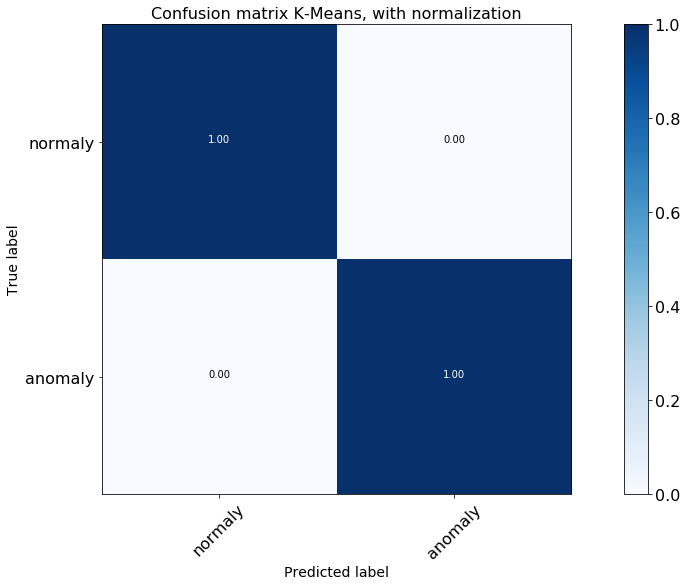

In [138]:
y_pred = 2*(layers_test["dist_red"] > th_km)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix K-Means, with normalization')

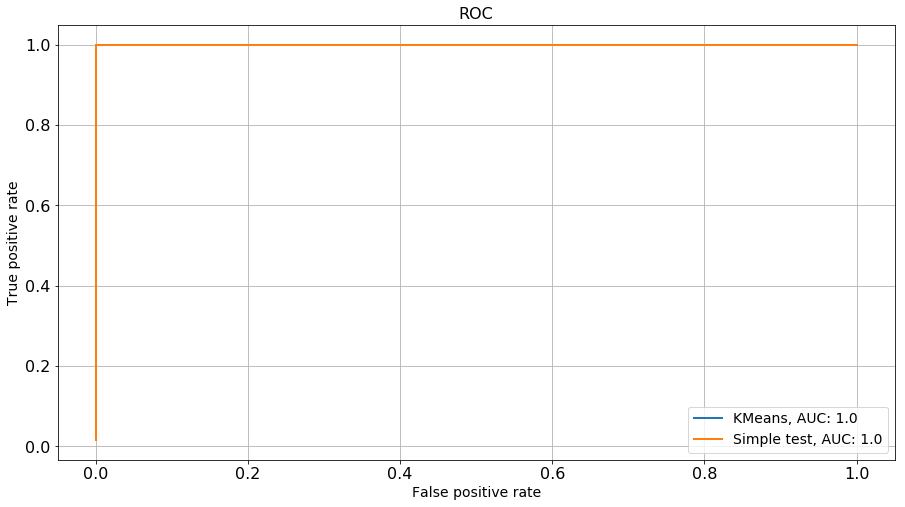

In [139]:
get_roc_curve(layers_test,[
                           #("Variance", "variance_score"),
                           #("IF", "if_score"),
                           #("SVM", "svm_score"),
                           #("AE", "cae_score"),
                           ("KMeans", "dist_red"),
                           #("DNN", "ann_score_4"),
                           ("Simple test", "st_score"),
                          ]
             )

In [140]:
filename = './model_sktlearn/kmeans_red_2018.sav'
joblib.dump(k_means_red, filename)

['./model_sktlearn/kmeans_red_2018.sav']

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


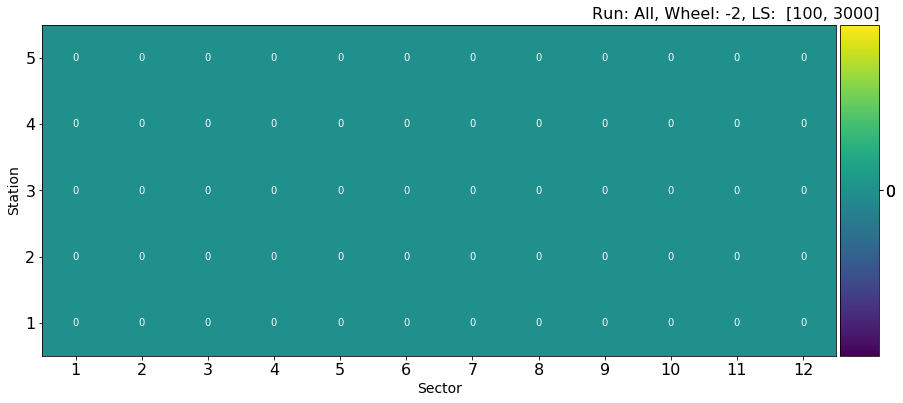

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


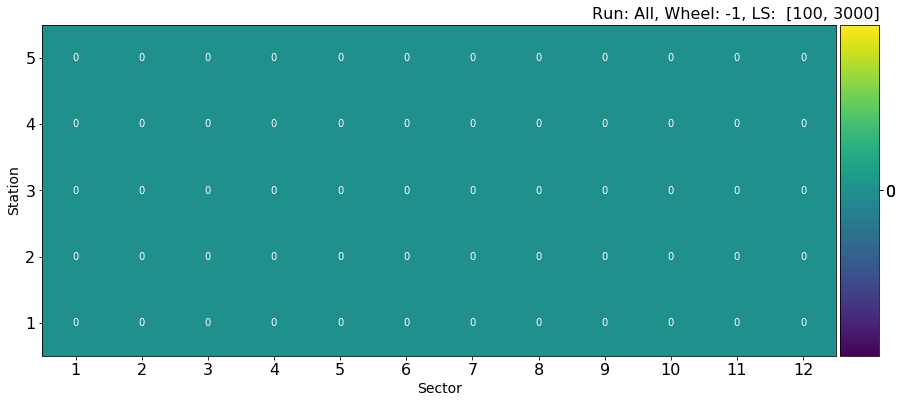

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


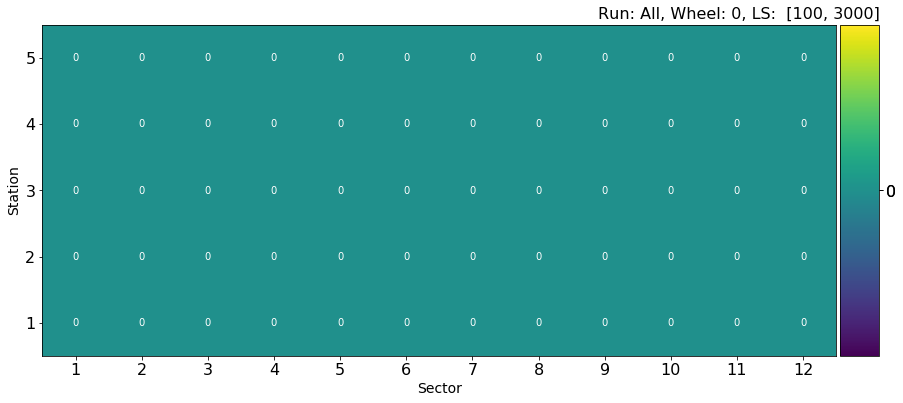

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


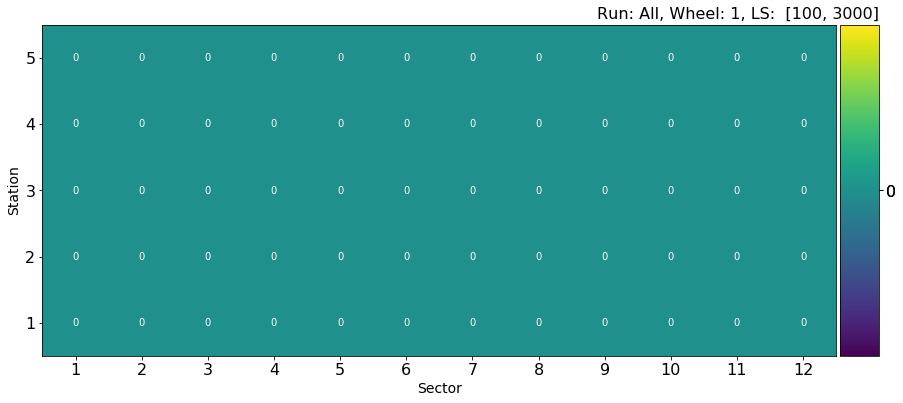

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


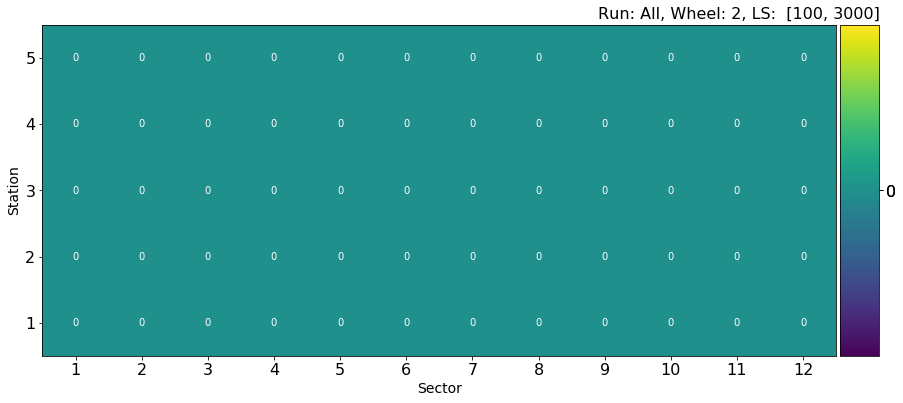

In [141]:
dis_nn = "dist_red"
th_km = 0.4
rule = (layers_test["score"] == -1) & (layers_test[dis_nn] > th_km)

plot_scatter(layers_test[rule], -1, -2, 100, 3000)
plot_scatter(layers_test[rule], -1, -1, 100, 3000)
plot_scatter(layers_test[rule], -1, 0, 100, 3000)
plot_scatter(layers_test[rule], -1, +1, 100, 3000)
plot_scatter(layers_test[rule], -1, +2, 100, 3000)

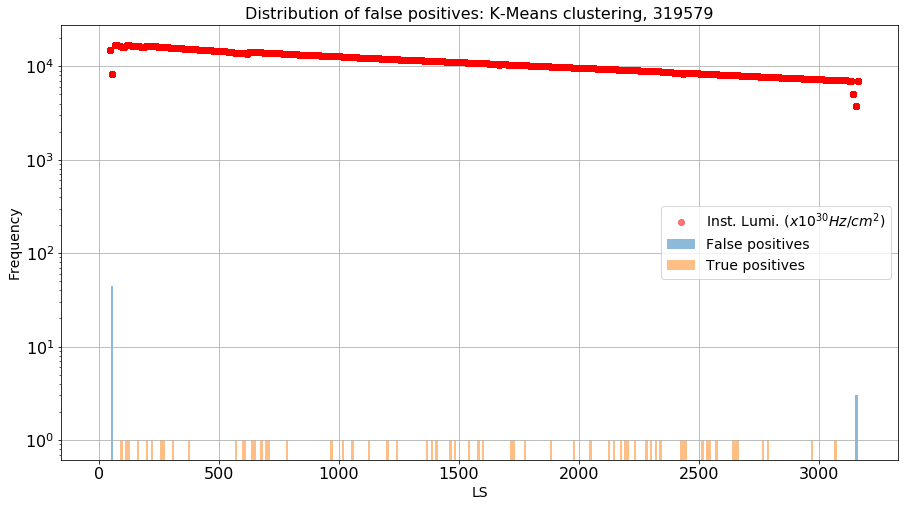

array([  0.,   0.,   0.,   0.,   0.,  44.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [142]:
layers_test["averageLS"] = layers_test["group"].apply(deduceLS)
threshold = 0.4
plotFpVsLs(319579, 0, 0, 0, "Distribution of false positives: K-Means clustering, ",\
           layers_test, "dist_red",\
           threshold, True, boundaries[boundaries["run"] == 319579]["ls_end"])

## LOF reduced

In [143]:
# fit the model
lofclf = LocalOutlierFactor(n_neighbors=201, contamination=0.02)#It has to be a odd number
layers_test["lof_score_red"] = -lofclf.fit_predict(np.vstack(layers_test["content_red"].values))

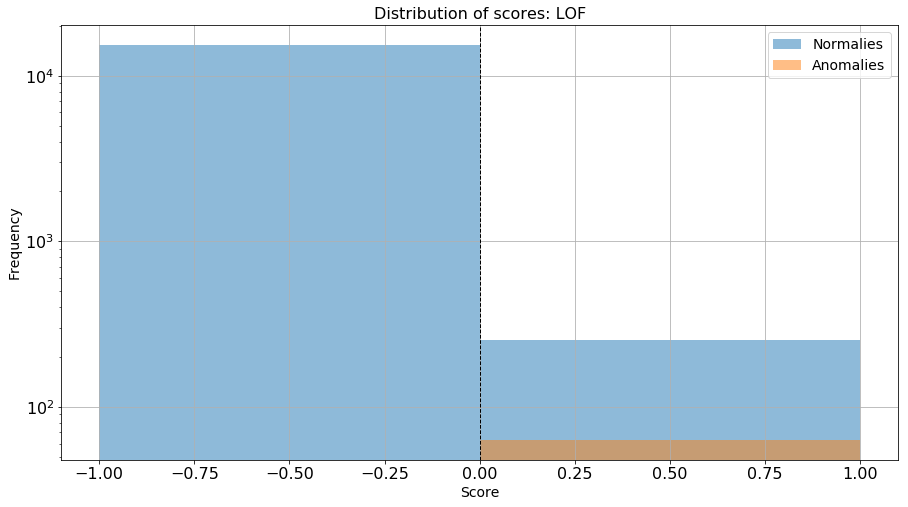

In [144]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(-1, +1, 3)
plt.hist(layers_test[layers_test["score"] < 0]["lof_score_red"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_test[layers_test["score"] > 0]["lof_score_red"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("Distribution of scores: LOF")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.axvline(0.0, color='k', linestyle='dashed', linewidth=1)
plt.show()